# Experimental Design for Compton Scattering

This notebook produces all figures for our experimental design project.
It is made succinct and readable because most detailed code resides in the `compton` package.

## Setup

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

import numpy as np
import scipy as sp
from scipy.optimize import check_grad
from scipy import stats
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import ticker
import pandas as pd
from os import path
import seaborn as sns
from matplotlib import gridspec as gs
from sklearn.utils.extmath import cartesian

from matplotlib.ticker import MaxNLocator
from matplotlib.ticker import MultipleLocator

from compton import create_observable_set, pol_vec_trans_tex_names
from compton import proton_pol_vec_mean, proton_pol_vec_std
from compton import neutron_pol_vec_mean, neutron_pol_vec_std
from compton import proton_pol_vec_trans_std, proton_pol_vec_trans_mean
from compton import neutron_pol_vec_trans_std, neutron_pol_vec_trans_mean

from compton import plot_subsets, compute_all_1pt_utilities, compute_max_utilities
from compton import plot_comparison_subsets_for_observables
from compton import offset_scatterplot_data
from compton import plot_utilities_all_observables
from compton import plot_comparison_subsets_and_truncation
from compton import convert_max_utilities_to_dataframe, convert_max_utilities_to_flat_dataframe
from compton import ComptonExperiment, create_experiment_infos

Set up global plot settings.

In [2]:
fontsize = 8
black = 'k'

mpl.rcdefaults()  # Set to defaults

mpl.rc('text', usetex=True)
mpl.rcParams['font.size'] = fontsize
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'

mpl.rcParams['axes.labelsize'] = fontsize
mpl.rcParams['axes.edgecolor'] = black
# mpl.rcParams['axes.xmargin'] = 0
mpl.rcParams['axes.labelcolor'] = black
mpl.rcParams['axes.linewidth']
mpl.rcParams['axes.titlesize'] = fontsize

mpl.rcParams['ytick.direction'] = 'in'
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['xtick.labelsize'] = fontsize
mpl.rcParams['ytick.labelsize'] = fontsize
mpl.rcParams['xtick.color'] = black
mpl.rcParams['ytick.color'] = black
mpl.rcParams['xtick.minor.size'] = 2.4
mpl.rcParams['ytick.minor.size'] = 2.4

mpl.rcParams['legend.title_fontsize'] = fontsize
mpl.rcParams['legend.fontsize'] = fontsize
mpl.rcParams['legend.edgecolor'] = 'inherit'  # inherits from axes.edgecolor, to match
mpl.rcParams['legend.facecolor'] = (1, 1, 1, 0.6)  # Set facecolor with its own alpha, so edgecolor is unaffected
mpl.rcParams['legend.fancybox'] = True
mpl.rcParams['legend.borderaxespad'] = 0.8
mpl.rcParams['legend.framealpha'] = None  # Do not set overall alpha (affects edgecolor). Handled by facecolor above
mpl.rcParams['patch.linewidth'] = 0.8  # This is for legend edgewidth, since it does not have its own option

mpl.rcParams['hatch.linewidth'] = 0.5

mpl.rc('savefig', transparent=False, bbox='tight', pad_inches=0.05, dpi=300, format='png')
mpl.rcParams['figure.dpi'] = 150

These colors will be used throughout

In [3]:
proton_cmap = plt.get_cmap('Reds')
neutron_cmap = plt.get_cmap('Blues')
nucleon_cmaps = {'neutron': neutron_cmap, 'proton': proton_cmap}

proton_color = proton_cmap(0.55)
neutron_color = neutron_cmap(0.55)

## Read in Data

Start by reading in raw data, and then get it into a form that is more readable.

In [4]:
obs_file = path.abspath('../data/polarisabilities-coefficient-table-for-all-observables_20191111_jam.csv')
df = pd.read_csv(obs_file, dtype={'observable': str})

In [5]:
omega_lab_unique = df['omegalab [MeV]'].unique()
degrees_lab_unique = df['thetalab [deg]'].unique()
n_omega = len(omega_lab_unique)
n_angle = len(degrees_lab_unique)

In [6]:
X = cartesian([omega_lab_unique, degrees_lab_unique])
X

array([[  5.,   1.],
       [  5.,   5.],
       [  5.,  10.],
       ...,
       [340., 170.],
       [340., 175.],
       [340., 180.]])

For most of the study, using *all* of these kinematic points is overkill, downsample to a more reasonable number within the reach of experiments.

In [7]:
X_reduced = X[(X[:, 1] > 30) & (X[:, 1] < 150) & (X[:, 0] > 50)]
X_reduced = X_reduced[(X_reduced[:, 0] % 2 == 0) & (X_reduced[:, 1] % 2 == 0)]
omega_lab_reduced_unique = np.unique(X_reduced[:, 0])
degrees_lab_reduced_unique = np.unique(X_reduced[:, 1])

In [9]:
degrees_lab_reduced_unique

array([ 40.,  50.,  60.,  70.,  80.,  90., 100., 110., 120., 130., 140.])

In [10]:
omega_lab_reduced_unique

array([ 60.,  70.,  80.,  90., 100., 110., 120., 130., 140., 148., 152.,
       160., 170., 180., 190., 200., 210., 220., 230., 240., 250., 260.,
       270., 280., 290., 300., 310., 320., 330., 340.])

Rename observables

In [11]:
observables_unique_raw = df['observable'].unique()
observables_unique_raw
observables_unique_raw[0] = 'dsg'

In [12]:
observables_unique_raw

array(['dsg', '1X', '1Z', '2X', '2Z', '3', 'Y', '3Y', '3Yp', '1Xp', '1Zp',
       '2Xp', '2Zp'], dtype=object)

In [13]:
dsg_label = r'$\sigma$'

observables_name_map = {
    'crosssection': dsg_label,
    '1X': r'$\Sigma_{1x}$',
    '1Z': r'$\Sigma_{1z}$',
    '2X': r'$\Sigma_{2x}$',
    '2Z': r'$\Sigma_{2z}$',
    '3': r'$\Sigma_{3}$',
    'Y': r'$\Sigma_{y}$',
    '3Y': r'$\Sigma_{3y}$',
    '3Yp': r"$\Sigma_{3y'}$",
    '1Xp': r"$\Sigma_{1x'}$",
    '1Zp': r"$\Sigma_{1z'}$",
    '2Xp': r"$\Sigma_{2x'}$",
    '2Zp': r"$\Sigma_{2z'}$",
}

In [14]:
df['observable'] = df['observable'].replace(observables_name_map)
observables_unique = df['observable'].unique()

Observables are constructed as (ratios of) $A + B^T \vec{a} + \vec{a}^T C \vec{a}$, for the polarizabilities $\vec{a}$.

In [15]:
df

,omegalab [MeV],thetalab [deg],observable,nucleon,order,is_numerator,A,B1,B2,B3,...,C33,C34,C35,C36,C44,C45,C46,C55,C56,C66
0,5.0,1,$\sigma$,proton,3,1,23.550624,-0.001971,-0.001971,4.278199e-07,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,5.0,1,$\sigma$,proton,3,0,1.000000,0.000000,0.000000,0.000000e+00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,5.0,5,$\sigma$,proton,3,1,23.463893,-0.001963,-0.001963,4.271897e-07,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,5.0,5,$\sigma$,proton,3,0,1.000000,0.000000,0.000000,0.000000e+00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,5.0,10,$\sigma$,proton,3,1,23.195600,-0.001941,-0.001941,4.251508e-07,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284747,340.0,170,$\Sigma_{2z'}$,neutron,4,0,1539.171610,22.347716,-22.350937,4.854397e+01,...,1.775510,-3.452411,3.354500,-3.452411,1.775510,-3.452411,3.354500,1.726380,-3.355539,1.726380
284748,340.0,175,$\Sigma_{2z'}$,neutron,4,1,1404.223925,36.547947,-36.547947,2.941353e+01,...,0.006110,0.012220,-0.012198,-0.012198,0.006110,-0.012198,-0.012198,0.006088,0.012177,0.006088
284749,340.0,175,$\Sigma_{2z'}$,neutron,4,0,1535.901865,22.339037,-22.339236,4.810882e+01,...,1.735146,-3.445853,3.421456,-3.445853,1.735146,-3.445853,3.421456,1.722937,-3.421521,1.722937
284750,340.0,180,$\Sigma_{2z'}$,neutron,4,1,1402.767299,36.552870,-36.552870,2.930796e+01,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [16]:
df[['omegalab [MeV]', 'thetalab [deg]']]

,omegalab [MeV],thetalab [deg]
0,5.0,1
1,5.0,1
2,5.0,5
3,5.0,5
4,5.0,10
...,...,...
284747,340.0,170
284748,340.0,175
284749,340.0,175
284750,340.0,180


In [17]:
sd_exp = 0.05  # Guess from fig A.9 from Martel Thesis

## Transform to a more natural basis

We must make the transformation
\begin{align*}
\vec{\xi} \to \vec{\xi}' \equiv P \vec{\xi}
\end{align*}
that is
\begin{align*}
\begin{bmatrix}
\alpha + \beta \\
\alpha - \beta \\
\gamma_0 \\
\gamma_\pi \\
\gamma_{E-} \\
\gamma_{M-}
\end{bmatrix}
\equiv
\begin{bmatrix}
    1 &  1 &  0 &  0 &  0 &  0 \\
    1 & -1 &  0 &  0 &  0 &  0 \\
    0 &  0 & -1 & -1 & -1 & -1 \\
    0 &  0 & -1 &  1 & -1 &  1 \\
    0 &  0 &  1 &  0 & -1 &  0 \\
    0 &  0 &  0 &  1 &  0 & -1
\end{bmatrix}
\begin{bmatrix}
\alpha \\ \beta \\ \gamma_{E1E1} \\ \gamma_{M1M1} \\ \gamma_{E1M2} \\ \gamma_{M1E2}
\end{bmatrix}
\end{align*}

This is not an orthogonal transformation but for the new utility formula this is not a problem. So everything is good!

In [18]:
P = np.array([
    [1,  1,  0,  0,  0,  0],
    [1, -1,  0,  0,  0,  0],
    [0,  0, -1, -1, -1, -1],
    [0,  0, -1,  1, -1,  1],
    [0,  0,  1,  0, -1,  0],
    [0,  0,  0,  1,  0, -1]
])
P_inv = np.linalg.inv(P)

## Does linearization work well?

Our utility function expects the observables to be linearly related to the polarizabilities.
We must check if this is a good approximation.

In [19]:
from compton import plot_observables_true_vs_linearized, neutron_pol_vec_mean, neutron_pol_vec_std

Create some predictions with no error estimate. To check linearization approximations, we only need the prediction. They will also be needed later to create errors that are a percentage of the differential cross section prediction.

In [20]:
cov_p_proton = np.diag(proton_pol_vec_std)
cov_p_neutron = np.diag(neutron_pol_vec_std)

cov_p_proton_trans = np.diag(proton_pol_vec_trans_std)
cov_p_neutron_trans = np.diag(neutron_pol_vec_trans_std)  # Need real values for this!!!

In [21]:
# No transform, no error estimate
compton_obs_no_error = create_observable_set(
    df=df, cov_exp=0., cov_p_proton=cov_p_proton, cov_p_neutron=cov_p_neutron
)

# No truncation
compton_obs_trans_no_error = create_observable_set(
    df=df, cov_exp=0., p_transform=P, cov_p_proton=cov_p_proton_trans, cov_p_neutron=cov_p_neutron_trans
)

This is our prior, linearize about the mean values.

In [22]:
df_pol_priors = pd.DataFrame({
    'mean (p)': proton_pol_vec_trans_mean,
    'stdv (p)': proton_pol_vec_trans_std,
    'mean (n)': neutron_pol_vec_trans_mean,
    'stdv (n)': neutron_pol_vec_trans_std,
    }, index=pol_vec_trans_tex_names)
df_pol_priors

,mean (p),stdv (p),mean (n),stdv (n)
$\alpha+\beta$,13.8,0.400000,15.200000,0.400000
$\alpha-\beta$,7.6,0.900000,7.900000,0.900000
$\gamma_{0}$,-1.0,0.141421,0.502780,0.141421
$\gamma_{\pi}$,8.0,1.800000,7.479912,1.800000
$\gamma_{E-}$,-0.7,1.992486,-3.887608,1.992486
$\gamma_{M-}$,0.3,0.927362,-0.888566,0.927362


We can paste this into our TeX file!

In [23]:
print(df_pol_priors.to_latex(escape=False, float_format="{:0.2f}".format))

\begin{tabular}{lrrrr}
\toprule
{} &  mean (p) &  stdv (p) &  mean (n) &  stdv (n) \\
\midrule
$\alpha+\beta$ &     13.80 &      0.40 &     15.20 &      0.40 \\
$\alpha-\beta$ &      7.60 &      0.90 &      7.90 &      0.90 \\
$\gamma_{0}$   &     -1.00 &      0.14 &      0.50 &      0.14 \\
$\gamma_{\pi}$ &      8.00 &      1.80 &      7.48 &      1.80 \\
$\gamma_{E-}$  &     -0.70 &      1.99 &     -3.89 &      1.99 \\
$\gamma_{M-}$  &      0.30 &      0.93 &     -0.89 &      0.93 \\
\bottomrule
\end{tabular}



Sample some polarizability values

In [24]:
n_pol_samples = 1000

np.random.seed(1)

proton_pol_trans_samples = stats.norm(
    loc=proton_pol_vec_trans_mean, scale=proton_pol_vec_trans_std
).rvs((n_pol_samples, len(proton_pol_vec_trans_mean)))
neutron_pol_trans_samples = stats.norm(
    loc=neutron_pol_vec_trans_mean, scale=neutron_pol_vec_trans_std
).rvs((n_pol_samples, len(neutron_pol_vec_trans_mean)))


proton_pol_samples = stats.norm(
    loc=proton_pol_vec_mean, scale=proton_pol_vec_std
).rvs((n_pol_samples, len(proton_pol_vec_mean)))
neutron_pol_samples = stats.norm(
    loc=neutron_pol_vec_mean, scale=neutron_pol_vec_std
).rvs((n_pol_samples, len(neutron_pol_vec_mean)))

In [25]:
proton_pol_trans_samples.shape

(1000, 6)

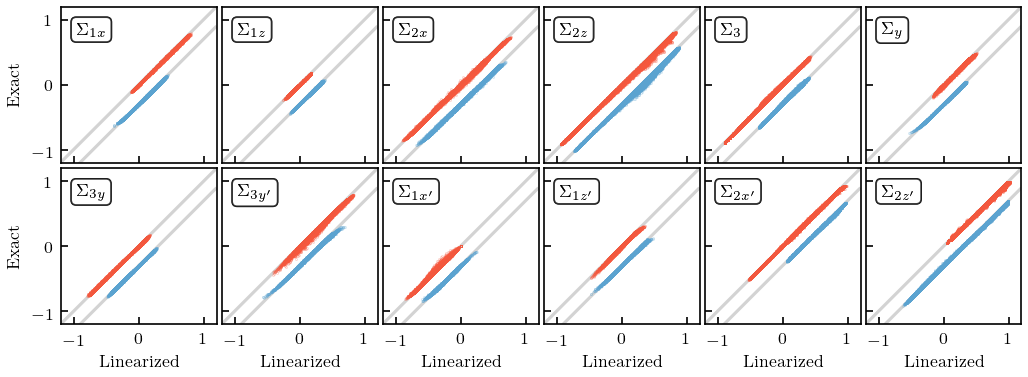

In [26]:
with plt.rc_context({"text.usetex": True, "text.latex.preview": True}):
    fig, axes = plot_observables_true_vs_linearized(
        compton_obs_trans_no_error, proton_pol_trans_samples, nucleon='proton',
        omega=omega_lab_reduced_unique, degrees=degrees_lab_reduced_unique,
        observables=observables_unique[1:], color=proton_color
    );
    plot_observables_true_vs_linearized(
        compton_obs_trans_no_error, neutron_pol_trans_samples, nucleon='neutron',
        omega=omega_lab_reduced_unique, degrees=degrees_lab_reduced_unique,
        observables=observables_unique[1:], color=neutron_color, offset=0.3, axes=axes
    );
    fig.savefig('spin_observables_true_vs_linearized_both_trans')
    plt.show()

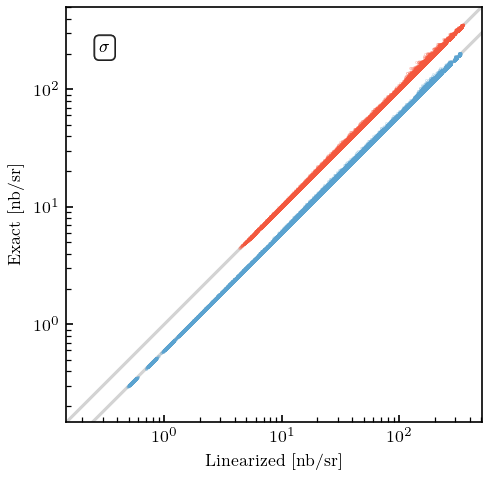

In [27]:
with plt.rc_context({"text.usetex": True, "text.latex.preview": True}):
    fig, ax = plt.subplots(1, 1, figsize=(3.4, 3.4))
    axes = np.atleast_2d(ax)
    fig, axes = plot_observables_true_vs_linearized(
        compton_obs_trans_no_error, proton_pol_trans_samples, nucleon='proton',
        omega=omega_lab_reduced_unique, degrees=degrees_lab_reduced_unique,
        observables=observables_unique[[0]], color=proton_color, axes=axes
    );
    plot_observables_true_vs_linearized(
        compton_obs_trans_no_error, neutron_pol_trans_samples, nucleon='neutron',
        omega=omega_lab_reduced_unique, degrees=degrees_lab_reduced_unique,
        observables=observables_unique[[0]], color=neutron_color, offset=0.6, axes=axes
    );
    fig.savefig('dsg_true_vs_linearized_both_trans')
    plt.show()

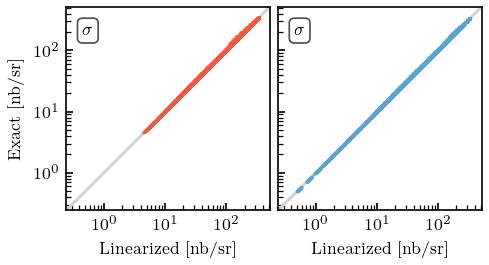

In [28]:
with plt.rc_context({"text.usetex": True, "text.latex.preview": True}):
    fig, axes = plt.subplots(1, 2, figsize=(3.4, 5), sharex=True, sharey=True)
    fig, _ = plot_observables_true_vs_linearized(
        compton_obs_trans_no_error, proton_pol_trans_samples, nucleon='proton',
        omega=omega_lab_reduced_unique, degrees=degrees_lab_reduced_unique,
        observables=observables_unique[[0]], color=proton_color, axes=axes[[0]]
    );
    plot_observables_true_vs_linearized(
        compton_obs_trans_no_error, neutron_pol_trans_samples, nucleon='neutron',
        omega=omega_lab_reduced_unique, degrees=degrees_lab_reduced_unique,
        observables=observables_unique[[0]], color=neutron_color, axes=axes[[1]]
    );
    axes[1].set_ylabel('')
    xlim = axes[1].get_xlim()
    axes[1].set_xticks(axes[0].get_yticks(minor=True), minor=True)
    axes[1].set_xticks(axes[0].get_yticks(minor=False), minor=False)
    axes[1].set_xlim(xlim)
    fig.tight_layout(w_pad=0.5)
    fig.savefig('dsg_true_vs_linearized_both_trans2')
    plt.show()

Compare these plots to samples from the untransformed prior, where correlations between $\alpha$ and $\beta$ were not imposed.

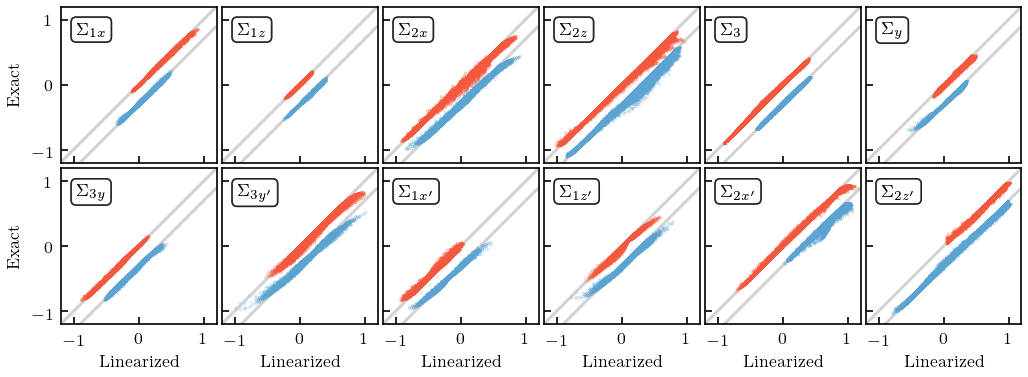

In [29]:
with plt.rc_context({"text.usetex": True, "text.latex.preview": True}):
    fig, axes = plot_observables_true_vs_linearized(
        compton_obs_no_error, proton_pol_samples, nucleon='proton',
        omega=omega_lab_reduced_unique, degrees=degrees_lab_reduced_unique,
        observables=observables_unique[1:], color=proton_color
    );
    plot_observables_true_vs_linearized(
        compton_obs_no_error, neutron_pol_samples, nucleon='neutron',
        omega=omega_lab_reduced_unique, degrees=degrees_lab_reduced_unique,
        observables=observables_unique[1:], color=neutron_color,offset=0.3, axes=axes
    );
    fig.savefig('spin_observables_true_vs_linearized_both')
    plt.show()

## Define Truncation and Experimental Errors

In [30]:
from sklearn.gaussian_process.kernels import RBF

In [31]:
def create_cov_th(X, sd=1, ls=0, noise=0):
    if ls == 0:
        corr = np.eye(len(X))
    else:
        corr = RBF(ls)(X)
        
    sd = np.array(sd)
    if sd.ndim == 0 or sd.ndim == 2:
        cov = sd**2 * corr
    elif sd.ndim == 1:
        cov = sd[:, None] * sd * corr
    else:
        raise ValueError('sd must be 0, 1 or 2d')
        
    noise = np.array(noise)
    if noise.ndim == 0:
        cov += noise**2 * np.eye(cov.shape[0])
    elif noise.ndim == 1:
        cov += np.diag(noise**2)
    elif noise.ndim == 2:
        cov += noise**2
    else:
        raise ValueError('noise must be 0, 1 or 2d')

    return cov

In [32]:
from compton import RBFJump, expansion_parameter_transfer_cm, mass_proton, mass_neutron, order_transition

# breakdown = 650  # Not big enough
breakdown = 700

# Fourth order is complete at low energy, so omitted is 5
# But it is not complete at high energy, so it goes to 2
# No, it actually goes to 1!
# omitted_order = order_transition(5, 2, X[:, 0])
omitted_order = order_transition(5, 1, X[:, 0])

# Q becomes greater than one... need a better definition
Q = expansion_parameter_transfer_cm(X, breakdown, mass=mass_proton)
Q_proton = expansion_parameter_transfer_cm(X, breakdown, mass=mass_proton)
Q_neutron = expansion_parameter_transfer_cm(X, breakdown, mass=mass_neutron)

Q_mat_p = Q_proton[:, None] * Q_proton
Q_mat_n = Q_neutron[:, None] * Q_neutron

Q_sum_p = Q_mat_p**omitted_order / (1 - Q_mat_p)
Q_sum_n = Q_mat_n**omitted_order / (1 - Q_mat_n)

# Q_sum = np.zeros((Q.shape[0], Q.shape[0]))
# for i in range(100):
#     Qi = Q**(omitted_order+i)
#     Q_sum += Qi[:, None] * Qi

# # Qmat = Q[:, None] * Q
# # Q_sum = Qmat**omitted_order / (1 - Qmat)

# corr_mat = np.eye(Q.shape[0])
# R_mat = Q_sum * corr_mat

# cov_trunc = sd_exp**2 * np.eye(len(X)) + R_mat

These must be less than one to have a truncation error that converges

In [33]:
Q_proton.max(), Q_neutron.max()

(0.9368324202021225, 0.9370463823684728)

In [34]:
order_pred = 4
dsg_pred_proton = compton_obs_trans_no_error[dsg_label, 'proton', order_pred, 'nonlinear'](proton_pol_vec_trans_mean)
dsg_pred_neutron = compton_obs_trans_no_error[dsg_label, 'neutron', order_pred, 'nonlinear'](neutron_pol_vec_trans_mean)

In [35]:
dsg_pred_proton

array([ 23.52280699,  23.43821506,  23.17479577, ..., 120.95081088,
       120.52784915, 120.38555429])

In [46]:
from compton import observables_name_map

In [47]:
kernel_kwargs = {
    ('dsg', 'proton'): dict(std=1, ls_omega=50, ls_degrees=100, noise_std=0, degrees_zeros=None, height=150),
    ('1X', 'proton'): dict(std=0.4, ls_omega=50, ls_degrees=100, noise_std=0, degrees_zeros=[0, 180], height=8),
    ('1Z', 'proton'): dict(std=0.2, ls_omega=50, ls_degrees=50, noise_std=0, degrees_zeros=[0, 180], height=12),
    ('2X', 'proton'): dict(std=0.2, ls_omega=50, ls_degrees=50, noise_std=0, degrees_zeros=[0, 180], height=8),
    ('2Z', 'proton'): dict(std=1, ls_omega=50, ls_degrees=100, noise_std=0, degrees_zeros=None, height=4),
    ('3', 'proton'): dict(std=0.5, ls_omega=50, ls_degrees=50, noise_std=0, degrees_zeros=[0, 180], height=4),
    ('Y', 'proton'): dict(std=0.3, ls_omega=50, ls_degrees=100, noise_std=0, degrees_zeros=[0, 180], height=4),
    ('3Y', 'proton'): dict(std=0.3, ls_omega=50, ls_degrees=100, noise_std=0, degrees_zeros=[0, 180], height=12),
    ('3Yp', 'proton'): dict(std=0.3, ls_omega=50, ls_degrees=50, noise_std=0, degrees_zeros=[0, 180], height=4),
    ('1Xp', 'proton'): dict(std=0.3, ls_omega=50, ls_degrees=50, noise_std=0, degrees_zeros=[0, 180], height=12),
    ('1Zp', 'proton'): dict(std=0.2, ls_omega=50, ls_degrees=50, noise_std=0, degrees_zeros=[0, 180], height=4),
    ('2Xp', 'proton'): dict(std=1, ls_omega=50, ls_degrees=100, noise_std=0, degrees_zeros=[180], height=12),
    ('2Zp', 'proton'): dict(std=0.5, ls_omega=50, ls_degrees=50, noise_std=0, degrees_zeros=[0], height=4),
    #
    ('dsg', 'neutron'): dict(std=2, ls_omega=50, ls_degrees=100, noise_std=0, degrees_zeros=None, height=None),
    ('1X', 'neutron'): dict(std=0.4, ls_omega=50, ls_degrees=100, noise_std=0, degrees_zeros=[0, 180], height=None),
    ('1Z', 'neutron'): dict(std=0.2, ls_omega=50, ls_degrees=50, noise_std=0, degrees_zeros=[0, 180], height=None),
    ('2X', 'neutron'): dict(std=0.5, ls_omega=50, ls_degrees=50, noise_std=0, degrees_zeros=[0, 180], height=None),
    ('2Z', 'neutron'): dict(std=2, ls_omega=50, ls_degrees=100, noise_std=0, degrees_zeros=None, height=None),
    ('3', 'neutron'): dict(std=0.5, ls_omega=50, ls_degrees=50, noise_std=0, degrees_zeros=[0, 180], height=None),
    ('Y', 'neutron'): dict(std=0.3, ls_omega=50, ls_degrees=100, noise_std=0, degrees_zeros=[0, 180], height=None),
    ('3Y', 'neutron'): dict(std=0.3, ls_omega=50, ls_degrees=50, noise_std=0, degrees_zeros=[0, 180], height=None),
    ('3Yp', 'neutron'): dict(std=0.3, ls_omega=50, ls_degrees=50, noise_std=0, degrees_zeros=[0, 180], height=None),
    ('1Xp', 'neutron'): dict(std=0.2, ls_omega=50, ls_degrees=50, noise_std=0, degrees_zeros=[0, 180], height=None),
    ('1Zp', 'neutron'): dict(std=0.2, ls_omega=50, ls_degrees=50, noise_std=0, degrees_zeros=[0, 180], height=None),
    ('2Xp', 'neutron'): dict(std=1, ls_omega=50, ls_degrees=100, noise_std=0, degrees_zeros=[180], height=None),
    ('2Zp', 'neutron'): dict(std=1.5, ls_omega=50, ls_degrees=100, noise_std=0, degrees_zeros=[0], height=None),
}

kernel_kwargs = {(observables_name_map[name], nucleon): d for (name, nucleon), d in kernel_kwargs.items()}

# proton_cov_cbars = {
#     'dsg': 1.0,
#     '1X': 1.0,
#     '1Z': 1.0,
#     '2X': 1.0,
#     '2Z': 1.0,
#     '3': 1.0,
#     'Y': 1.0,
#     '3Y': 1.0,
#     '3Yp': 1.0,
#     '1Xp': 1.0,
#     '1Zp': 1.0,
#     '2Xp': 1.0,
#     '2Zp': 1.0,
# }

# proton_cov_length_scale_omega = {
#     'dsg': 50.0,
#     '1X': 50.0,
#     '1Z': 50.0,
#     '2X': 50.0,
#     '2Z': 50.0,
#     '3': 50.0,
#     'Y': 50.0,
#     '3Y': 50.0,
#     '3Yp': 50.0,
#     '1Xp': 50.0,
#     '1Zp': 50.0,
#     '2Xp': 50.0,
#     '2Zp': 50.0,
# }

# proton_cov_length_scale_degrees = {
#     'dsg': 20.0,
#     '1X': 20.0,
#     '1Z': 20.0,
#     '2X': 20.0,
#     '2Z': 20.0,
#     '3': 20.0,
#     'Y': 20.0,
#     '3Y': 20.0,
#     '3Yp': 20.0,
#     '1Xp': 20.0,
#     '1Zp': 20.0,
#     '2Xp': 20.0,
#     '2Zp': 20.0,
# }


# ############
# # Neutron
# ############

# neutron_cov_cbars = {
#     'dsg': 1.0,
#     '1X': 1.0,
#     '1Z': 1.0,
#     '2X': 1.0,
#     '2Z': 1.0,
#     '3': 1.0,
#     'Y': 1.0,
#     '3Y': 1.0,
#     '3Yp': 1.0,
#     '1Xp': 1.0,
#     '1Zp': 1.0,
#     '2Xp': 1.0,
#     '2Zp': 1.0,
# }

# neutron_cov_length_scale_omega = {
#     'dsg': 50.0,
#     '1X': 50.0,
#     '1Z': 50.0,
#     '2X': 50.0,
#     '2Z': 50.0,
#     '3': 50.0,
#     'Y': 50.0,
#     '3Y': 50.0,
#     '3Yp': 50.0,
#     '1Xp': 50.0,
#     '1Zp': 50.0,
#     '2Xp': 50.0,
#     '2Zp': 50.0,
# }

# neutron_cov_length_scale_degrees = {
#     'dsg': 20.0,
#     '1X': 20.0,
#     '1Z': 20.0,
#     '2X': 20.0,
#     '2Z': 20.0,
#     '3': 20.0,
#     'Y': 20.0,
#     '3Y': 20.0,
#     '3Yp': 20.0,
#     '1Xp': 20.0,
#     '1Zp': 20.0,
#     '2Xp': 20.0,
#     '2Zp': 20.0,
# }

In [37]:
# expts_info_standard = create_experiment_infos(
#     X, level='standard', dsg_pred_proton=dsg_pred_proton, dsg_pred_neutron=dsg_pred_neutron,
#     Q_sum_p=Q_sum_p, Q_sum_n=Q_sum_n, trunc=False
# )

# expts_info_standard_trunc = create_experiment_infos(
#     X, level='standard', dsg_pred_proton=dsg_pred_proton, dsg_pred_neutron=dsg_pred_neutron,
#     Q_sum_p=Q_sum_p, Q_sum_n=Q_sum_n, trunc=True
# )

# expts_info_doable = create_experiment_infos(
#     X, level='doable', dsg_pred_proton=dsg_pred_proton, dsg_pred_neutron=dsg_pred_neutron,
#     Q_sum_p=Q_sum_p, Q_sum_n=Q_sum_n, trunc=False
# )

# expts_info_doable_trunc = create_experiment_infos(
#     X, level='doable', dsg_pred_proton=dsg_pred_proton, dsg_pred_neutron=dsg_pred_neutron,
#     Q_sum_p=Q_sum_p, Q_sum_n=Q_sum_n, trunc=True
# )

# expts_info_aspirational = create_experiment_infos(
#     X, level='aspirational', dsg_pred_proton=dsg_pred_proton, dsg_pred_neutron=dsg_pred_neutron,
#     Q_sum_p=Q_sum_p, Q_sum_n=Q_sum_n, trunc=False
# )

# expts_info_aspirational_trunc = create_experiment_infos(
#     X, level='aspirational', dsg_pred_proton=dsg_pred_proton, dsg_pred_neutron=dsg_pred_neutron,
#     Q_sum_p=Q_sum_p, Q_sum_n=Q_sum_n, trunc=True
# )

Make two compton observable sets. One of which uses transformed parameters and the other does not.

In [38]:
# # Transform polarizabilities:

# # No truncation
# compton_obs_trans_standard = create_observable_set(
#     df=df, cov_exp=0., p_transform=P, cov_p_proton=cov_p_proton_trans,
#     cov_p_neutron=cov_p_neutron_trans, expts_info=expts_info_standard
# )
# compton_obs_trans_doable = create_observable_set(
#     df=df, cov_exp=0., p_transform=P, cov_p_proton=cov_p_proton_trans,
#     cov_p_neutron=cov_p_neutron_trans, expts_info=expts_info_doable
# )
# compton_obs_trans_aspire = create_observable_set(
#     df=df, cov_exp=0., p_transform=P, cov_p_proton=cov_p_proton_trans,
#     cov_p_neutron=cov_p_neutron_trans, expts_info=expts_info_aspirational
# )


# # Include truncation
# compton_obs_trans_standard_trunc = create_observable_set(
#     df=df, cov_exp=0., p_transform=P, cov_p_proton=cov_p_proton_trans,
#     cov_p_neutron=cov_p_neutron_trans, expts_info=expts_info_standard_trunc
# )
# compton_obs_trans_doable_trunc = create_observable_set(
#     df=df, cov_exp=0., p_transform=P, cov_p_proton=cov_p_proton_trans,
#     cov_p_neutron=cov_p_neutron_trans, expts_info=expts_info_doable_trunc
# )
# compton_obs_trans_aspire_trunc = create_observable_set(
#     df=df, cov_exp=0., p_transform=P, cov_p_proton=cov_p_proton_trans,
#     cov_p_neutron=cov_p_neutron_trans, expts_info=expts_info_aspirational_trunc
# )

## Compute Utilities for various assumptions

Define some objects that will be used to label plots below.

In [39]:
subset_names = ['all', r'$\alpha+\beta$', r'$\alpha-\beta$', r'$\gamma_i$']
subset_idxs = [
    [0, 1, 2, 3, 4, 5],
    [0],
    [1],
    [2, 3, 4, 5],
]
savenames = [
    'all',
    'amb',
    'apb',
    'gammas'
]

subsets = {name: idx for name, idx in zip(subset_names, subset_idxs)}
subset_savenames = {name: savename for name, savename in zip(subset_names, savenames)}

nucleons = ['proton', 'neutron']

n_angle_search = 5

In [40]:
observables_unique

array(['$\\sigma$', '$\\Sigma_{1x}$', '$\\Sigma_{1z}$', '$\\Sigma_{2x}$',
       '$\\Sigma_{2z}$', '$\\Sigma_{3}$', '$\\Sigma_{y}$',
       '$\\Sigma_{3y}$', "$\\Sigma_{3y'}$", "$\\Sigma_{1x'}$",
       "$\\Sigma_{1z'}$", "$\\Sigma_{2x'}$", "$\\Sigma_{2z'}$"],
      dtype=object)

In [41]:
expts_info_dicts = {}
compton_obs_dicts = {}
best_utils_1pt_dicts = {}
best_utils_npt_dicts = {}
best_utils_1pt_dfs = {}
best_utils_npt_dfs = {}
best_utils_1pt_flat_dfs = {}
best_utils_npt_flat_dfs = {}
util_dicts = {}

In [42]:
from tqdm import tqdm

This will take a while (2-3 minutes per `level, trunc` pair). Most of the time is due to the utility searching over all possible 5 angles. Computing everything up front makes all of the plotting much simpler later on.

In [49]:
with tqdm(total=6) as pbar:
    for level in ['standard', 'doable', 'aspirational']:
        for trunc in ['no_trunc', 'trunc']:
            is_trunc = (trunc == 'trunc')

            pbar.set_postfix(level=level, trunc=trunc, step='create expts', refresh=True)
            expts_info_i = create_experiment_infos(
                X, level=level, dsg_pred_proton=dsg_pred_proton, dsg_pred_neutron=dsg_pred_neutron,
                Q_sum_p=Q_sum_p, Q_sum_n=Q_sum_n, trunc=is_trunc, kernel_kwargs=kernel_kwargs
            )

            compton_obs_i = create_observable_set(
                df=df, cov_exp=0., p_transform=P, cov_p_proton=cov_p_proton_trans,
                cov_p_neutron=cov_p_neutron_trans, expts_info=expts_info_i
            )

            util_dict_i = compute_all_1pt_utilities(compton_obs_i, subsets)

            # Best n-point utilities
            pbar.set_postfix(level=level, trunc=trunc, step='n-points', refresh=True)
            best_utils_npt_dict_i = compute_max_utilities(
                compton_obs_i, subsets, omega_lab_reduced_unique,
                degrees_lab_reduced_unique, n_degrees=n_angle_search
            )

            best_utils_npt_df_i = convert_max_utilities_to_dataframe(
                best_utils_npt_dict_i, observable_order=observables_unique, subset_order=subset_names
            )

            best_utils_npt_flat_df_i = convert_max_utilities_to_flat_dataframe(
                best_utils_npt_dict_i, observable_order=observables_unique, subset_order=subset_names
            )

            # Best 1-point utilities
            pbar.set_postfix(level=level, trunc=trunc, step='1-point', refresh=True)
            best_utils_1pt_dict_i = compute_max_utilities(
                compton_obs_i, subsets, omega_lab_reduced_unique,
                degrees_lab_reduced_unique, n_degrees=1
            )

            best_utils_1pt_df_i = convert_max_utilities_to_dataframe(
                best_utils_1pt_dict_i, observable_order=observables_unique, subset_order=subset_names
            )

            best_utils_1pt_flat_df_i = convert_max_utilities_to_flat_dataframe(
                best_utils_1pt_dict_i, observable_order=observables_unique, subset_order=subset_names
            )

            expts_info_dicts[level, trunc] = expts_info_i
            compton_obs_dicts[level, trunc] = compton_obs_i
            best_utils_1pt_dicts[level, trunc] = best_utils_1pt_dict_i
            best_utils_npt_dicts[level, trunc] = best_utils_npt_dict_i
            best_utils_1pt_dfs[level, trunc] = best_utils_1pt_df_i
            best_utils_npt_dfs[level, trunc] = best_utils_npt_df_i
            best_utils_1pt_flat_dfs[level, trunc] = best_utils_1pt_flat_df_i
            best_utils_npt_flat_dfs[level, trunc] = best_utils_npt_flat_df_i
            util_dicts[level, trunc] = util_dict_i
            
            pbar.update(1)

100%|██████████| 6/6 [14:55<00:00, 149.24s/it, level=aspirational, step=1-point, trunc=trunc]        


## Make Plots



In [50]:
def setup_scatter_ticks(ax=None):
    if ax is None:
        ax = plt.gca()
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax_yticks = ax.get_yticks()
    ax.yaxis.set_minor_locator(MultipleLocator((ax_yticks[1] - ax_yticks[0])/2.))
    # ax.yaxis.set_minor_locator(MultipleLocator(0.5))
    ax.tick_params(
        direction='in', axis='both', which='both',
        bottom=True, top=False, left=True, right=True
    )
    return ax

********************
Level: standard
********************
Compare utility with and without truncation error


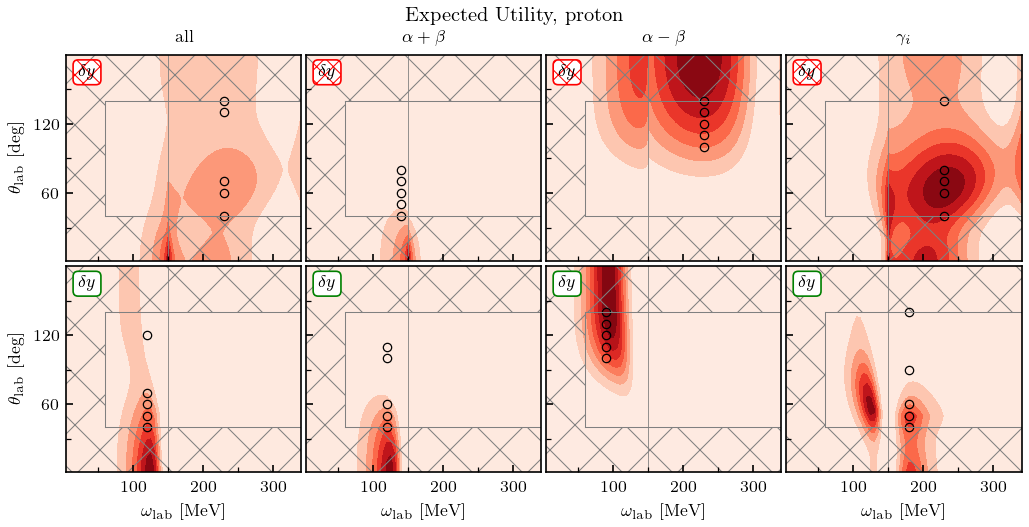

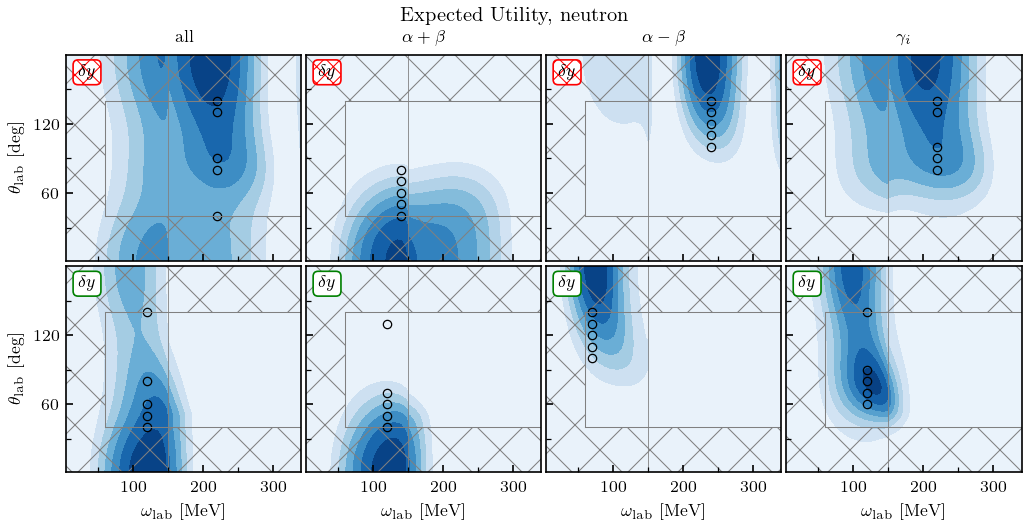

Compare n-point optimal design to 1-point optimal design


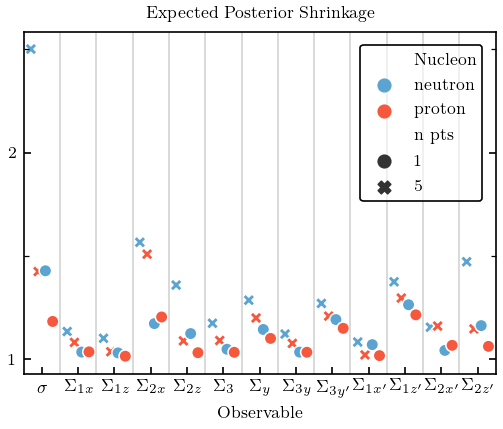

Plot utilities for all observables (with truncation and take all polarizabilities into account)


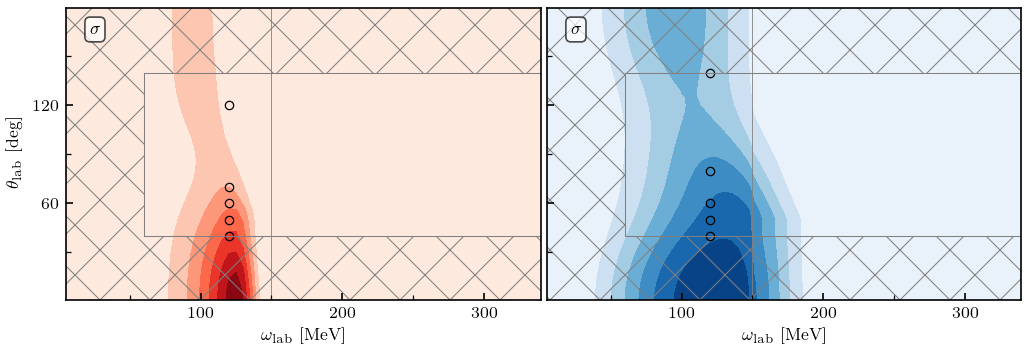

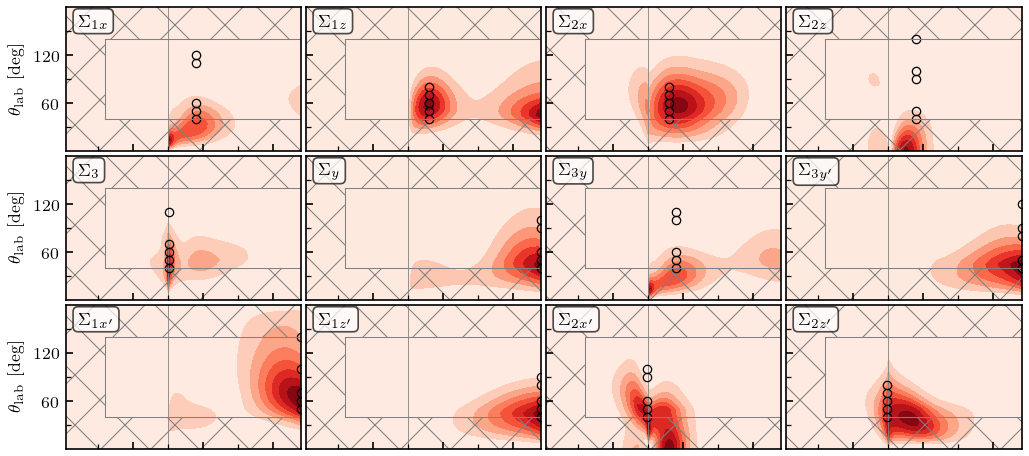

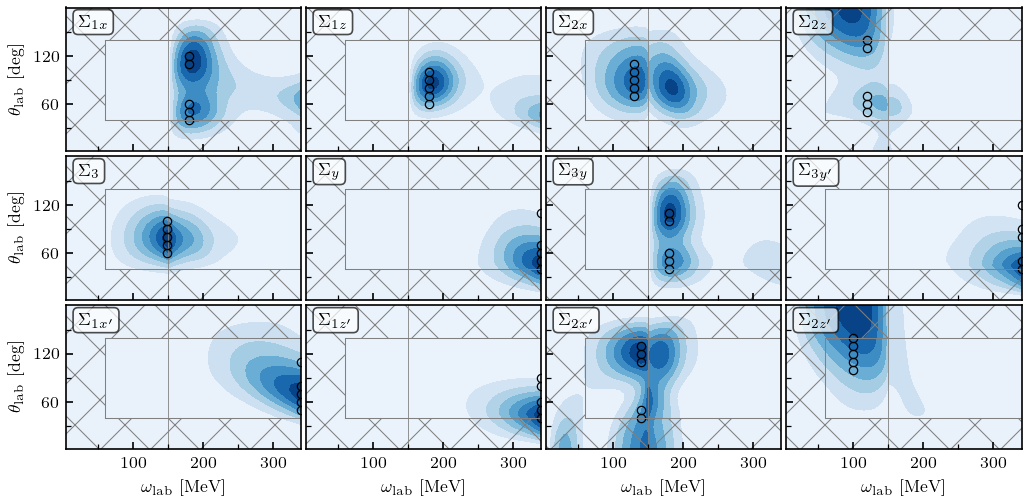

Compare shrinkage for each polarizability subset


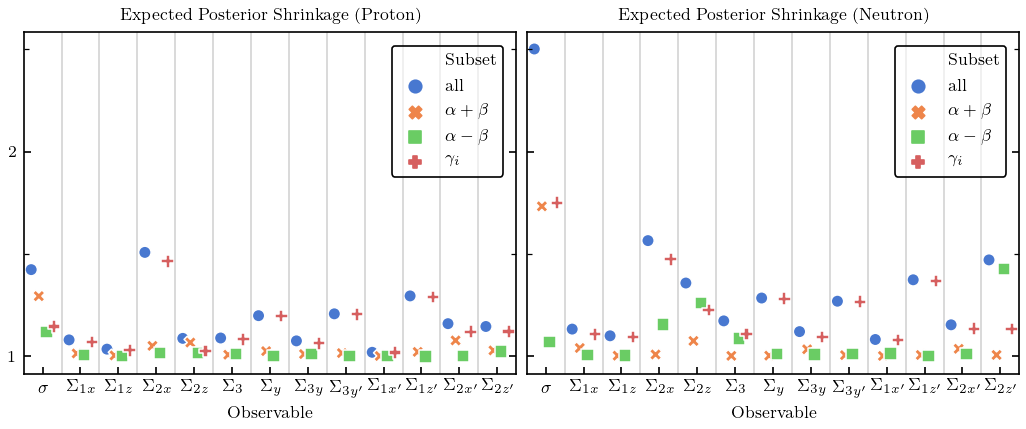

Show entire utility contours (with truncation) for remaining polarizability subsets


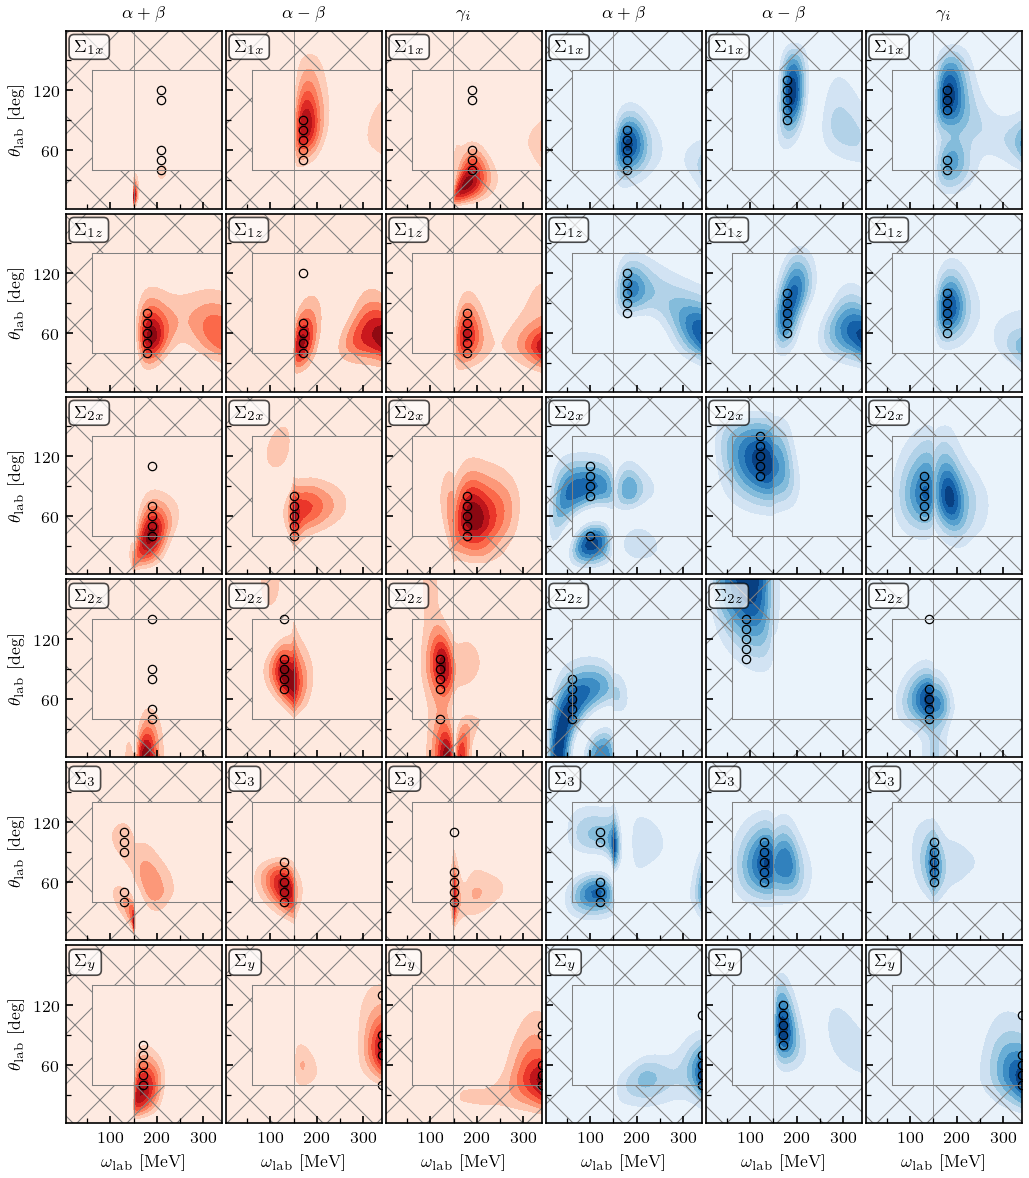

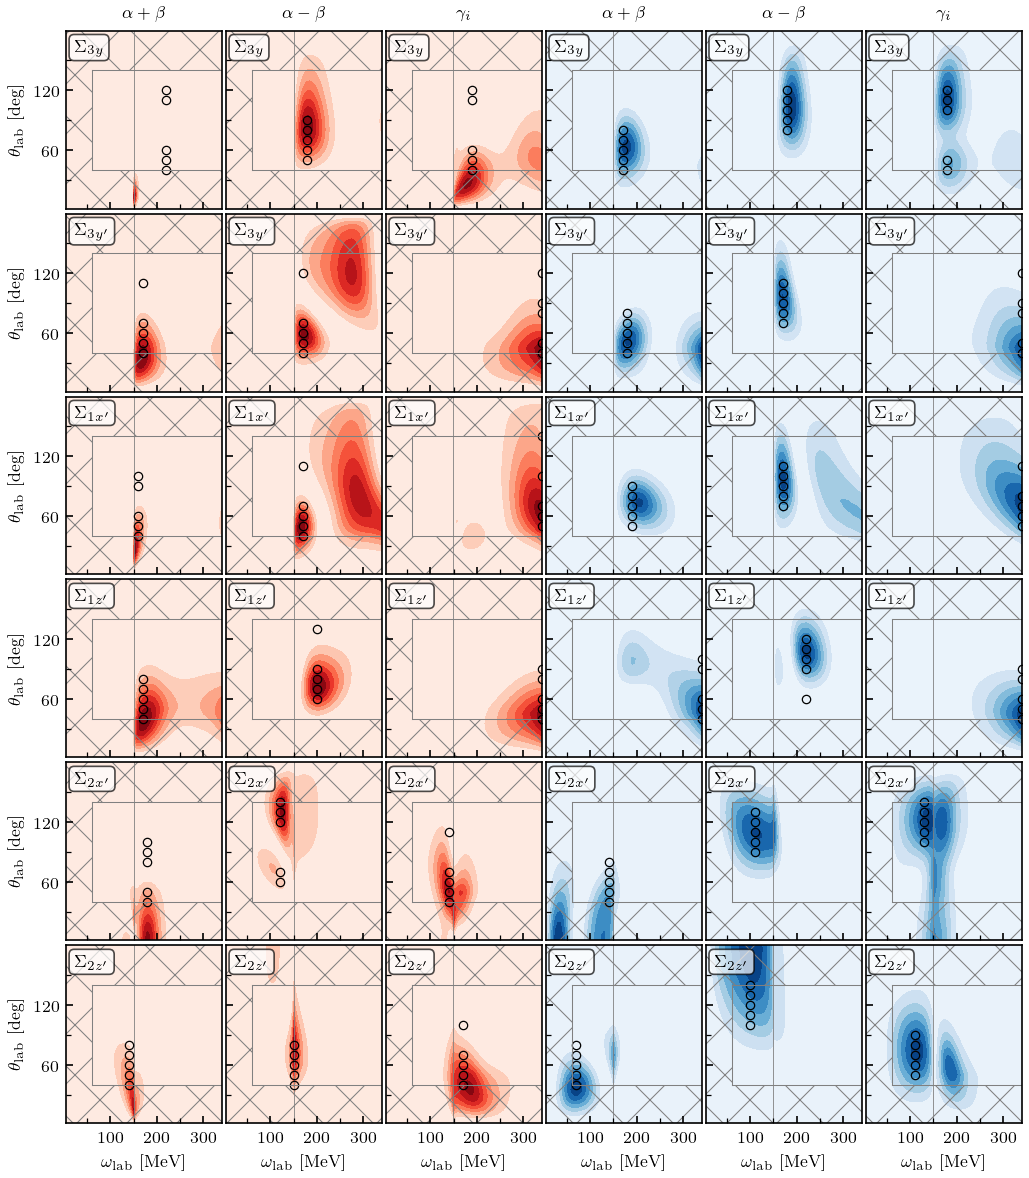

********************
Level: doable
********************
Compare utility with and without truncation error


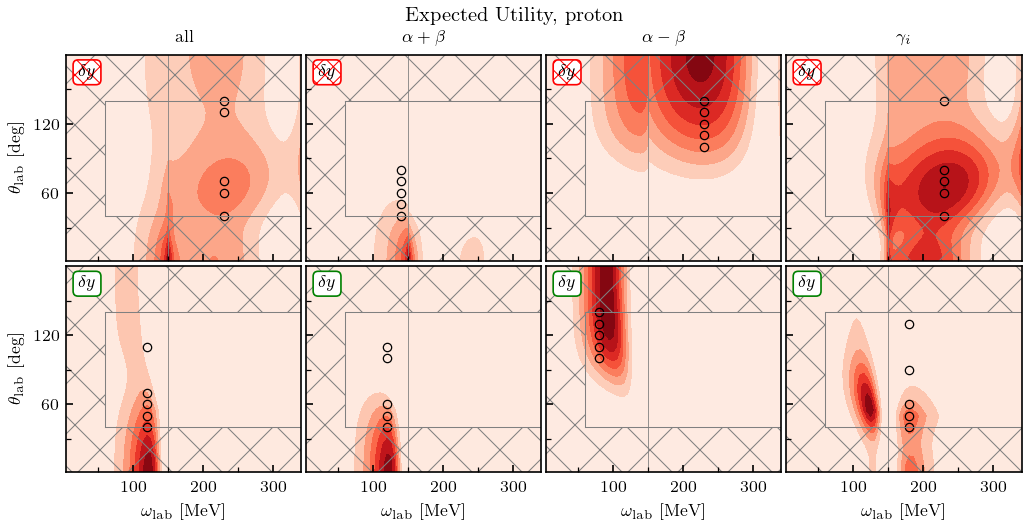

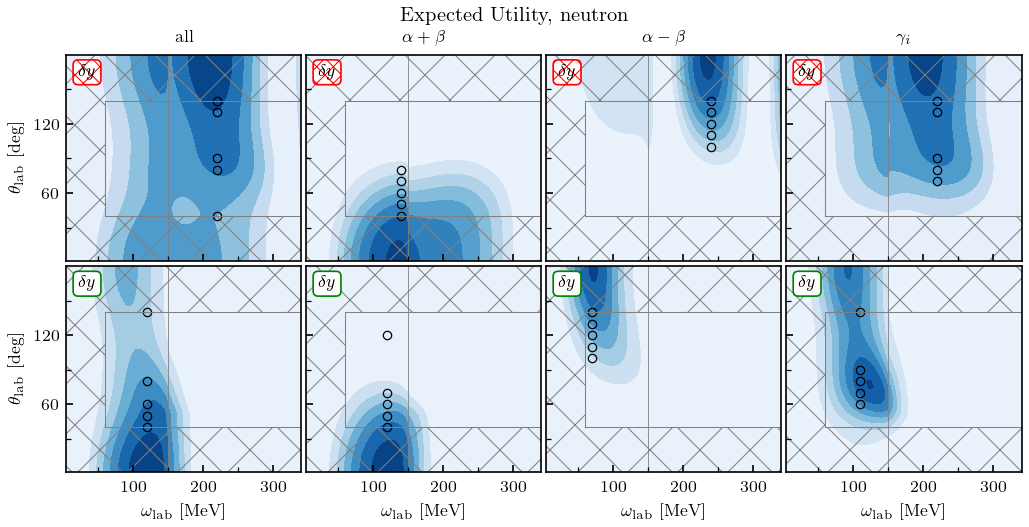

Compare n-point optimal design to 1-point optimal design


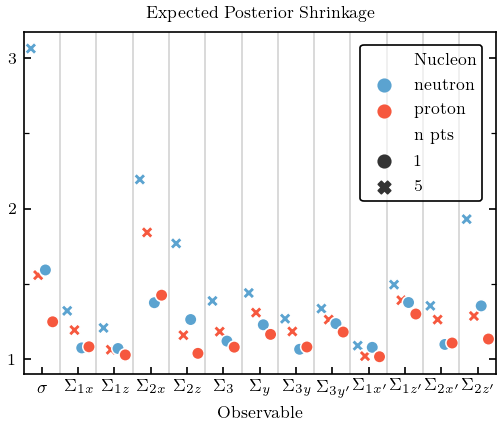

Plot utilities for all observables (with truncation and take all polarizabilities into account)


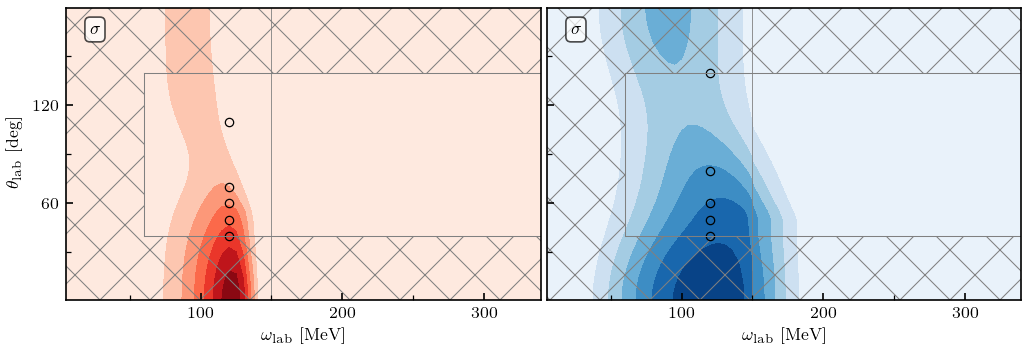

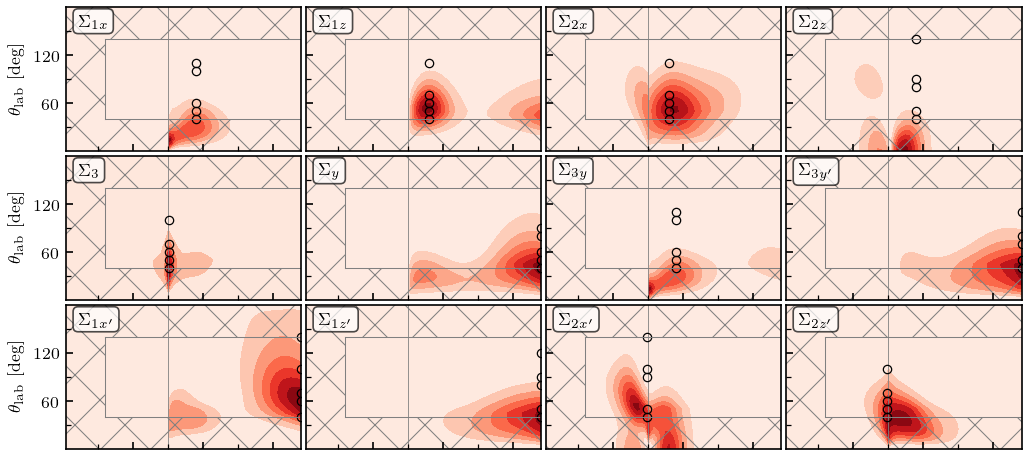

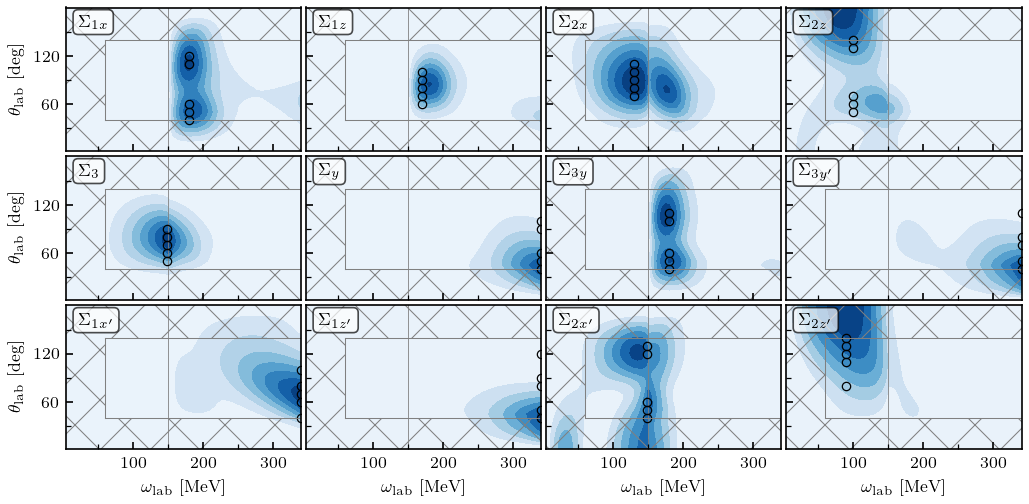

Compare shrinkage for each polarizability subset


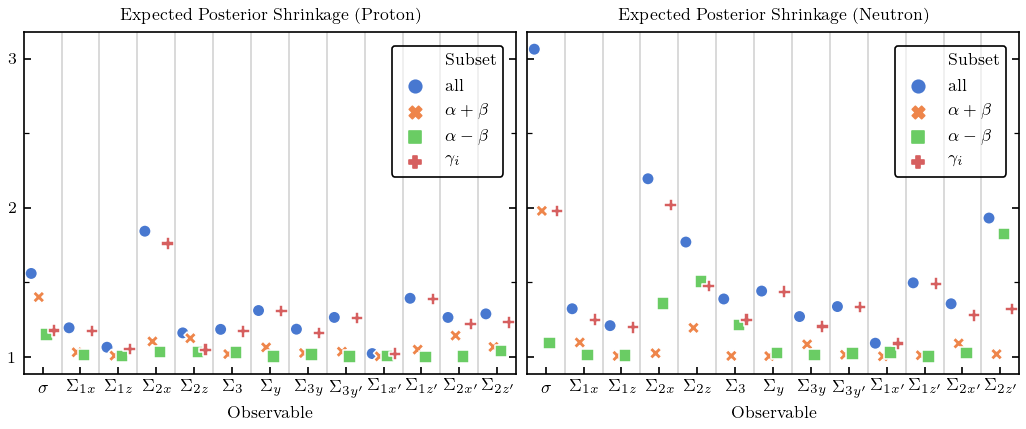

Show entire utility contours (with truncation) for remaining polarizability subsets


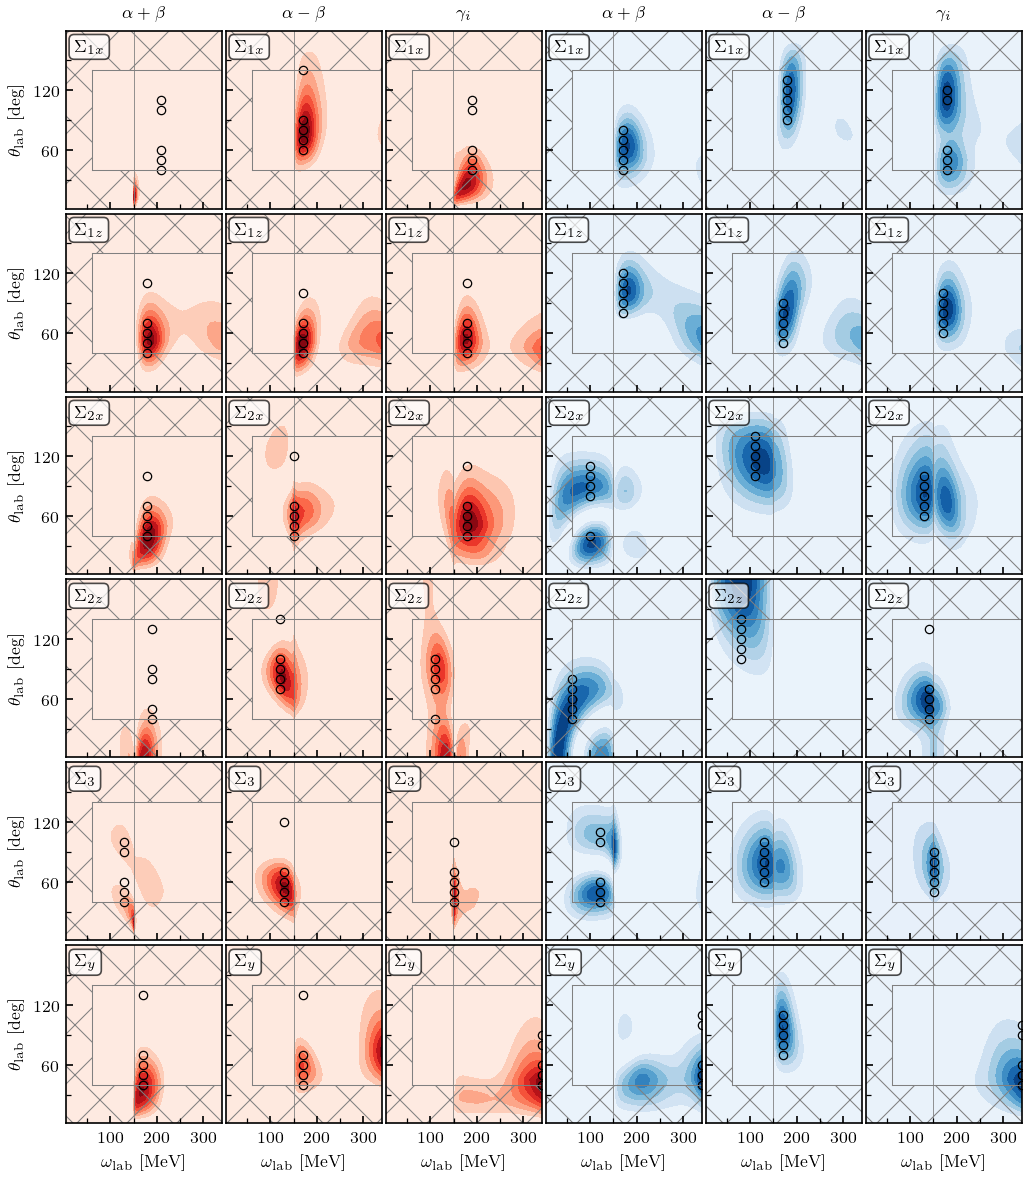

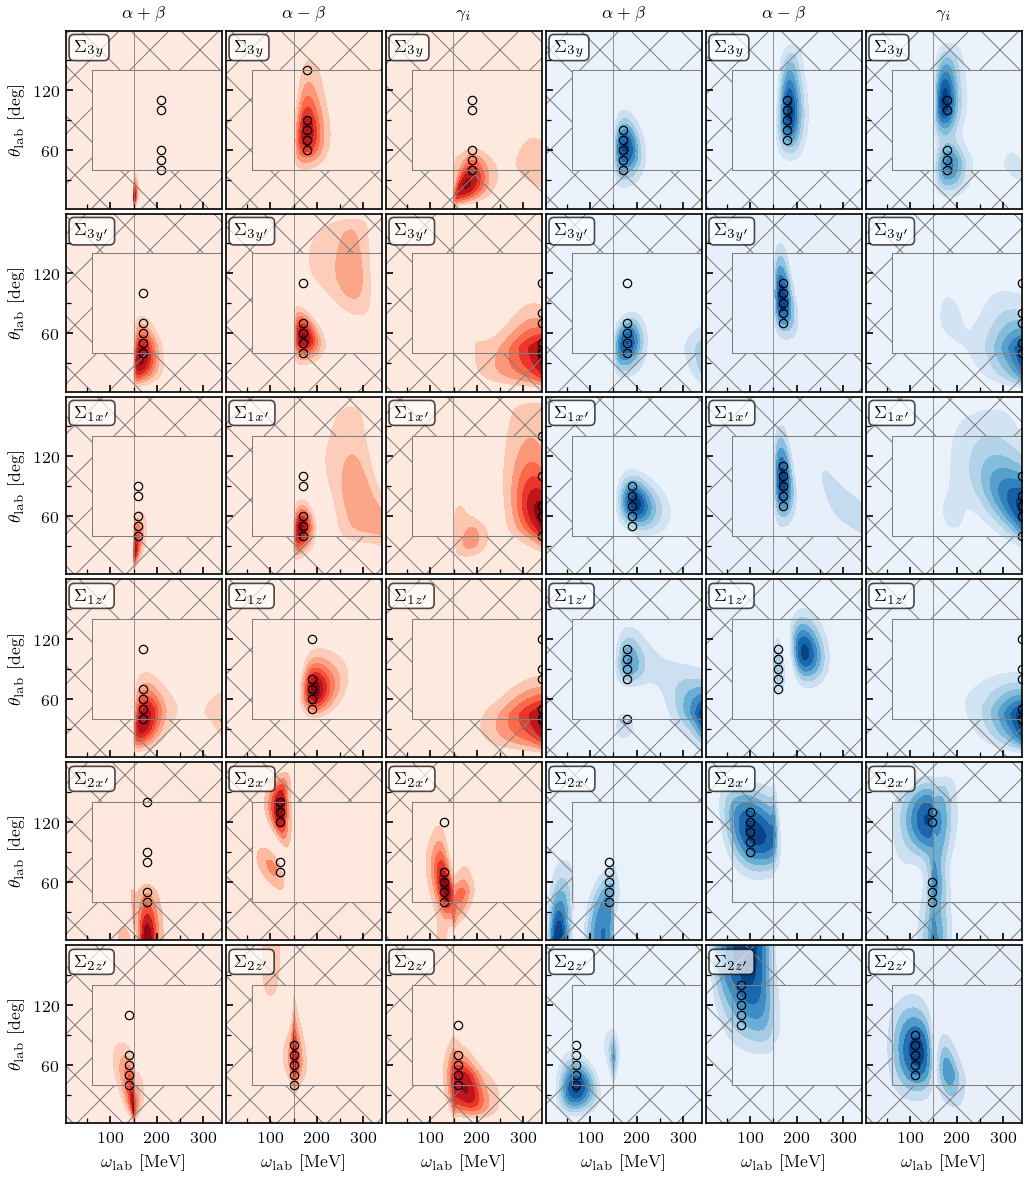

********************
Level: aspirational
********************
Compare utility with and without truncation error


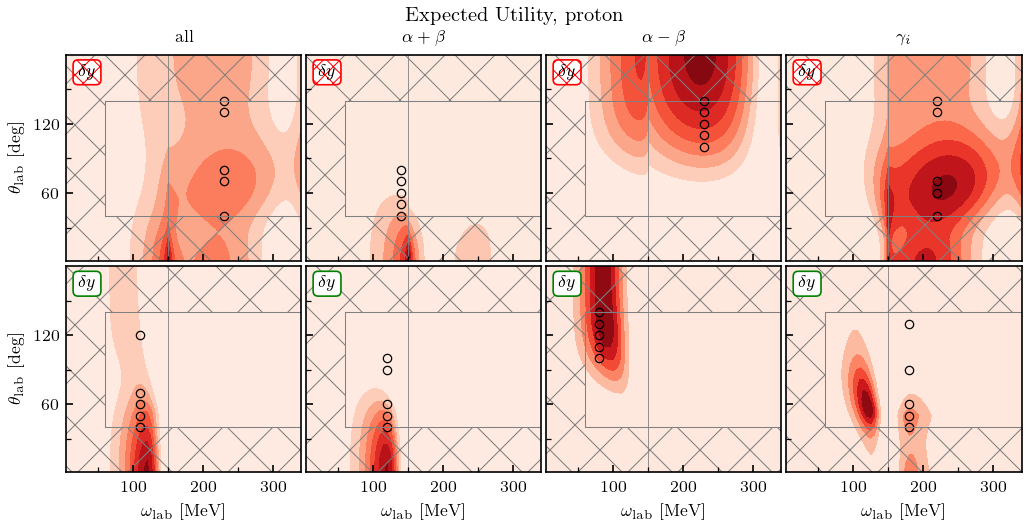

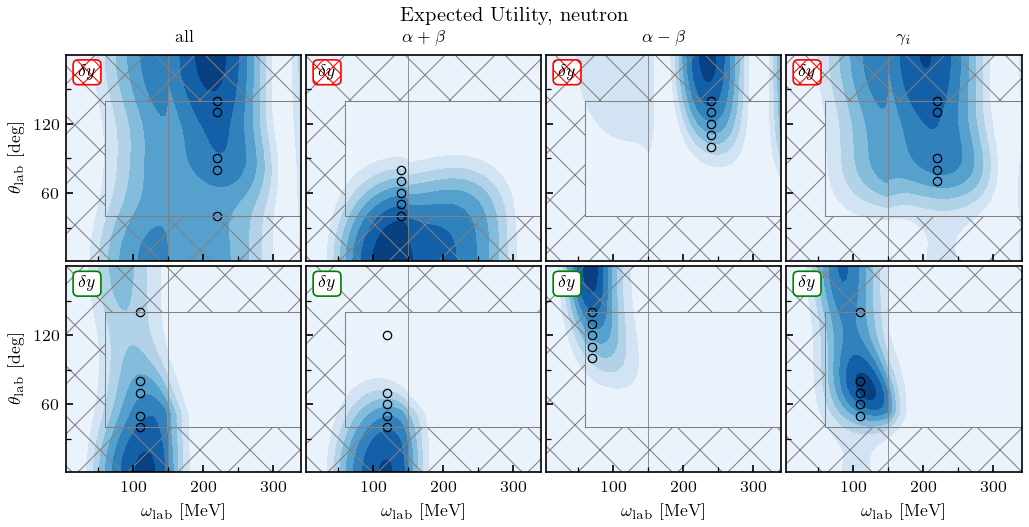

Compare n-point optimal design to 1-point optimal design


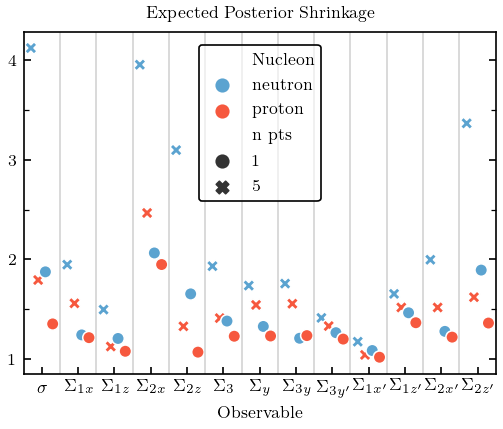

Plot utilities for all observables (with truncation and take all polarizabilities into account)


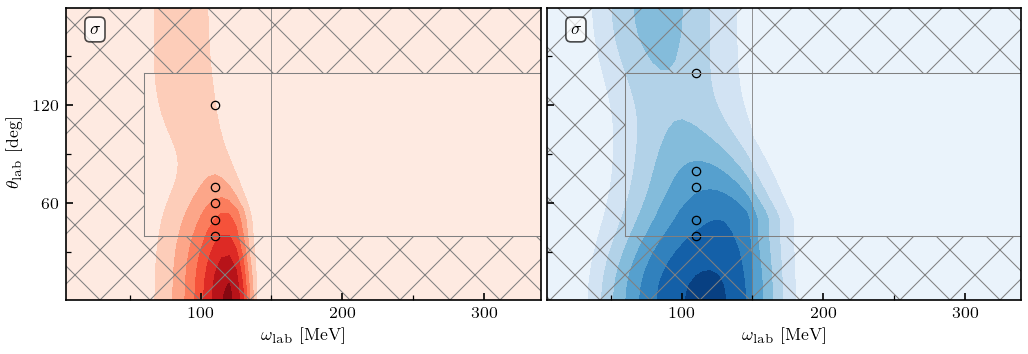

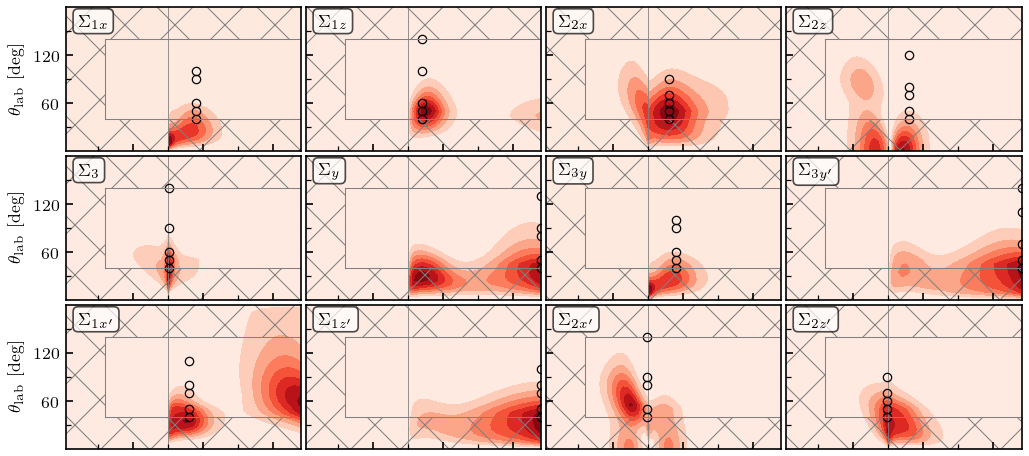

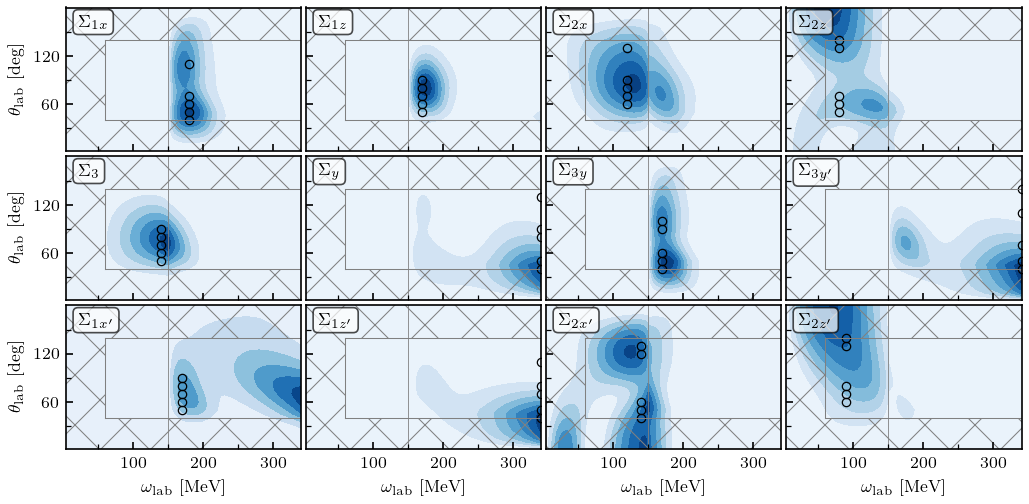

Compare shrinkage for each polarizability subset


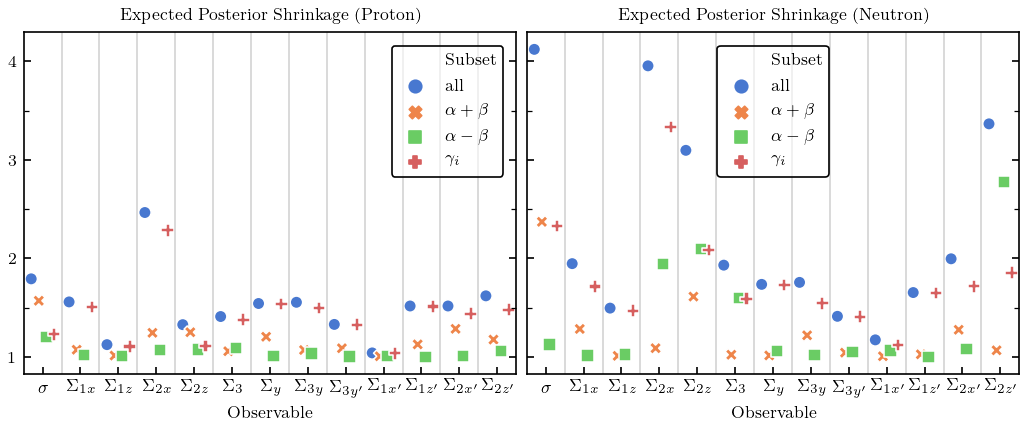

Show entire utility contours (with truncation) for remaining polarizability subsets


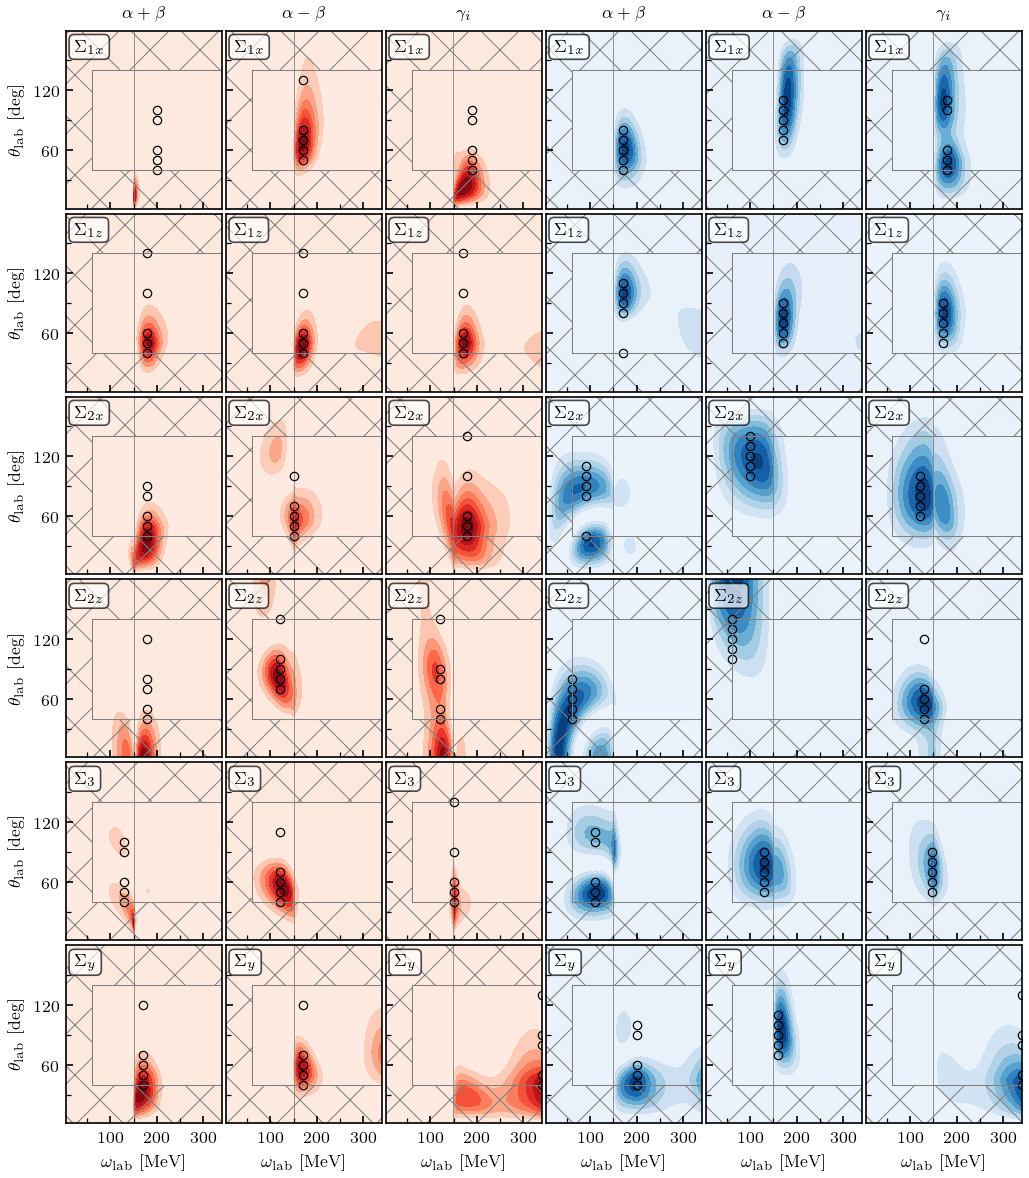

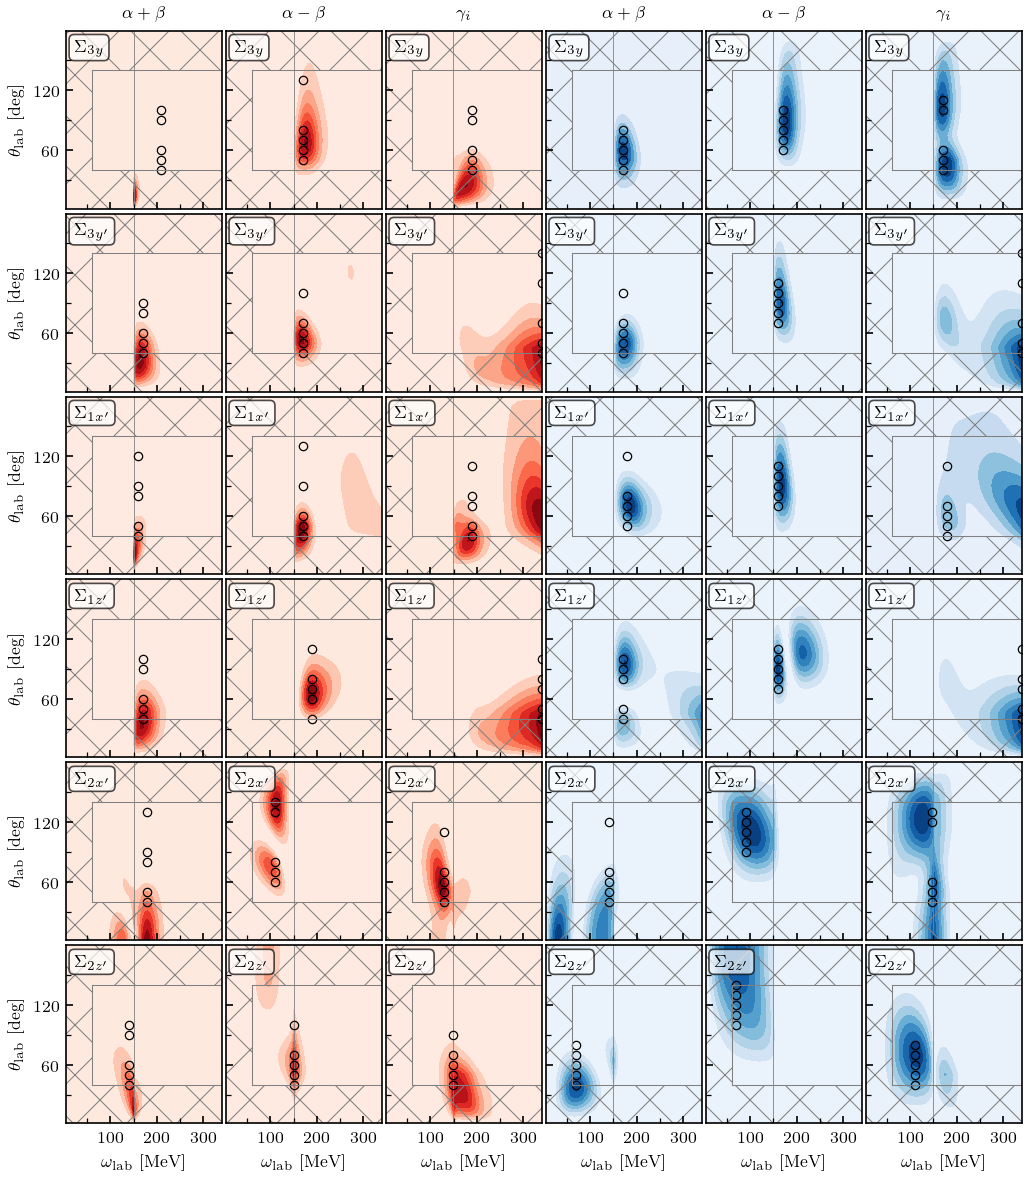

In [51]:
for level in ['standard', 'doable', 'aspirational']:
    
    print('*' * 20)
    print('Level:', level)
    print('*' * 20)
    
    #######################
    print('Compare utility with and without truncation error')
    #######################
    
    with plt.rc_context({"text.usetex": True, "text.latex.preview": True}):
        for nucleon in nucleons:
            fig, axes = plot_comparison_subsets_and_truncation(
                util_dicts[level, 'no_trunc'], util_dicts[level, 'trunc'],
                nucleon=nucleon, observable=r'$\sigma$',
                max_util_dict_no_trunc=best_utils_npt_dicts[level, 'no_trunc'],
                max_util_dict_with_trunc=best_utils_npt_dicts[level, 'trunc'],
                omega=omega_lab_unique, degrees=degrees_lab_unique, subsets=subset_names,
                degrees_min=np.min(degrees_lab_reduced_unique), degrees_max=np.max(degrees_lab_reduced_unique),
                omega_min=np.min(omega_lab_reduced_unique),
                cmap=nucleon_cmaps[nucleon],
            )
            fig.suptitle(f'Expected Utility, {nucleon}', y=1.01)
            fig.tight_layout(h_pad=0.3, w_pad=0.3)
            plt.show()
            fig.savefig(f'utility_{nucleon}_subsets_compare_subsets_and_truncation_level-{level}.pdf')
            
    
    #######################
    print('Compare n-point optimal design to 1-point optimal design')
    #######################
    
    bests_join_npt_1pt_df = pd.concat([
        best_utils_npt_dfs[level, 'trunc'],
        best_utils_1pt_dfs[level, 'trunc']
    ], sort=False)
    
    fig, ax = plt.subplots(figsize=(3.5, 3))

    bests_join_npt_1pt_df_all = bests_join_npt_1pt_df[bests_join_npt_1pt_df['Subset'] == 'all']
    bests_join_npt_1pt_df_all = bests_join_npt_1pt_df_all.sort_values(by=['Observable', 'Subset'], ascending=True)

    sns.scatterplot(
        x='Observable', y='Shrinkage', data=bests_join_npt_1pt_df_all,
        hue='Nucleon', style='n pts',
        palette={'neutron': neutron_color, 'proton': proton_color},
        ax=ax
    )
    ax.tick_params(direction='in')
    ax.set_title('Expected Posterior Shrinkage')
    ax.set_ylabel('')
    ax.set_xlabel('Observable')


    ax.set_xticks(np.arange(2*len(observables_unique)-1)/2., minor=True)
    ax.tick_params(direction='in', which='both')
    ax.tick_params(length=0, which='minor', axis='x')
    ax.grid(True, which='minor', axis='x', color='lightgrey')
    setup_scatter_ticks(ax)

    offset_scatterplot_data(4, ax)
    ax.set_xlim([-0.5, len(observables_unique)-0.5])

    fig.tight_layout()
    # plt.legend().set_bbox_to_anchor((1.01, 1))
    plt.show()
    fig.savefig(f'shrinkage_per_observable_all_polarizabilities_level-{level}')
    
    
    #######################
    print('Plot utilities for all observables (with truncation and take all polarizabilities into account)')
    #######################
    
    fig, axes = plt.subplots(1, 2, figsize=(7, 2.5), sharey=True)
    plot_utilities_all_observables(
        util_dicts[level, 'trunc'], 'proton', 'all',
        omega_lab_unique, degrees_lab_unique,
        max_util_dict=best_utils_npt_dicts[level, 'trunc'],
        degrees_min=np.min(degrees_lab_reduced_unique),
        degrees_max=np.max(degrees_lab_reduced_unique),
        omega_min=np.min(omega_lab_reduced_unique),
        cmap='Reds',
        axes=axes[[0]],
        observables=observables_unique[[0]]
    )

    plot_utilities_all_observables(
        util_dicts[level, 'trunc'], 'neutron', 'all',
        omega_lab_unique, degrees_lab_unique,
        max_util_dict=best_utils_npt_dicts[level, 'trunc'],
        degrees_min=np.min(degrees_lab_reduced_unique),
        degrees_max=np.max(degrees_lab_reduced_unique),
        omega_min=np.min(omega_lab_reduced_unique),
        cmap='Blues', observables=observables_unique[[0]],
        axes=axes[[1]],
    );
    axes[1].set_ylabel('')
    fig.tight_layout(w_pad=0.4)
    plt.show()
    fig.savefig(f'dsg_grid_with_best_npts_level-{level}')
    
    with plt.rc_context({"text.usetex": True, "text.latex.preview": True}):
        fig, axes = plot_utilities_all_observables(
            util_dicts[level, 'trunc'], 'proton', 'all',
            omega_lab_unique, degrees_lab_unique,
            max_util_dict=best_utils_npt_dicts[level, 'trunc'],
            degrees_min=np.min(degrees_lab_reduced_unique),
            degrees_max=np.max(degrees_lab_reduced_unique),
            omega_min=np.min(omega_lab_reduced_unique),
            cmap='Reds',
            observables=observables_unique[1:]
        )
        for ax in axes.ravel():
            ax.set_xlabel('')
            ax.set_xticklabels([])
        plt.show()
        fig.savefig(f'proton_spin_grid_with_best_npts_level-{level}')
        
    with plt.rc_context({"text.usetex": True, "text.latex.preview": True}):
        fig, axes = plot_utilities_all_observables(
            util_dicts[level, 'trunc'], 'neutron', 'all',
            omega_lab_unique, degrees_lab_unique,
            max_util_dict=best_utils_npt_dicts[level, 'trunc'],
            degrees_min=np.min(degrees_lab_reduced_unique),
            degrees_max=np.max(degrees_lab_reduced_unique),
            omega_min=np.min(omega_lab_reduced_unique),
            cmap='Blues', observables=observables_unique[1:]
        )
        plt.show()
        fig.savefig(f'neutron_spin_grid_with_best_npts_level-{level}')
        
        
    #######################
    print('Compare shrinkage for each polarizability subset')
    #######################    
    
    
    fig, axes = plt.subplots(1, 2, figsize=(7, 3), sharex=True, sharey=True)
    best_utils_npt_df_sort = best_utils_npt_dfs[level, 'trunc'].sort_values(
        by=['Observable', 'Subset'], ascending=True)
    palette = 'muted'

    sns.scatterplot(
        x='Observable', y='Shrinkage',
        data=best_utils_npt_df_sort[best_utils_npt_df_sort['Nucleon'] == 'proton'],
        hue='Subset',
        style='Subset',
        hue_order=subset_names,
        style_order=subset_names,
        palette=palette,
    #     color=proton_color,
        ax=axes[0]
    )

    sns.scatterplot(
        x='Observable', y='Shrinkage',
        data=best_utils_npt_df_sort[best_utils_npt_df_sort['Nucleon'] == 'neutron'],
        hue='Subset',
        style='Subset',
        hue_order=subset_names,
        style_order=subset_names,
        palette=palette,
    #     color=neutron_color,
        ax=axes[1]
    )

    axes[1].set_ylabel('')
    offset_scatterplot_data(4, axes[0])
    offset_scatterplot_data(4, axes[1])

    for ax in axes:
        ax.set_xticks(np.arange(2*len(observables_unique)-1)/2., minor=True)
        ax.tick_params(direction='in', which='both')
        ax.tick_params(length=0, which='minor', axis='x')
        ax.grid(True, which='minor', axis='x', color='lightgrey')

        setup_scatter_ticks(ax)
#         ax.yaxis.set_major_locator(MaxNLocator(integer=True))
#         ax_yticks = ax.get_yticks()
#         ax.yaxis.set_minor_locator(MultipleLocator((ax_yticks[1] - ax_yticks[0])/2.))
        ax.set_xlim([-0.5, len(observables_unique)-0.5])
    axes[0].set_ylabel('')
    axes[0].set_title('Expected Posterior Shrinkage (Proton)')
    axes[1].set_title('Expected Posterior Shrinkage (Neutron)')

    fig.tight_layout(w_pad=0.5)
    plt.show()
    fig.savefig(f'shrinkage_per_subset_level-{level}')
    
    
    #######################
    print('Show entire utility contours (with truncation) for remaining polarizability subsets')
    ####################### 
    
    
    with plt.rc_context({"text.usetex": True, "text.latex.preview": True}):
        fig, axes = plot_comparison_subsets_for_observables(
            util_dicts[level, 'trunc'], omega_lab_unique, degrees_lab_unique,
            max_util_dict=best_utils_npt_dicts[level, 'trunc'],
            degrees_min=np.min(degrees_lab_reduced_unique),
            degrees_max=np.max(degrees_lab_reduced_unique),
            omega_min=np.min(omega_lab_reduced_unique),
            cmap_p='Reds', cmap_n='Blues',
            observables=observables_unique[1:7],
            subsets=subset_names[1:]
        );
        plt.show()
        fig.savefig(f'utilities_for_subsets_observable_set_1_level-{level}')
        
    with plt.rc_context({"text.usetex": True, "text.latex.preview": True}):
        fig, axes = plot_comparison_subsets_for_observables(
            util_dicts[level, 'trunc'], omega_lab_unique, degrees_lab_unique,
            max_util_dict=best_utils_npt_dicts[level, 'trunc'],
            degrees_min=np.min(degrees_lab_reduced_unique),
            degrees_max=np.max(degrees_lab_reduced_unique),
            omega_min=np.min(omega_lab_reduced_unique),
            cmap_p='Reds', cmap_n='Blues',
            observables=observables_unique[7:],
            subsets=subset_names[1:]
        );
        plt.show()
        fig.savefig(f'utilities_for_subsets_observable_set_2_level-{level}')

## Compare between precision levels

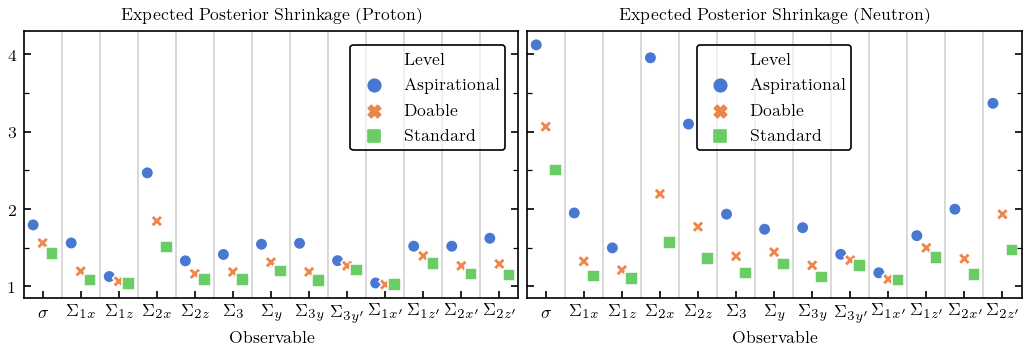

In [52]:
best_utils_npt_df_standard = best_utils_npt_dfs['standard', 'trunc']
best_utils_npt_df_doable = best_utils_npt_dfs['doable', 'trunc']
best_utils_npt_df_aspire = best_utils_npt_dfs['aspirational', 'trunc']

best_utils_npt_df_standard['Level'] = 'Standard'
best_utils_npt_df_doable['Level'] = 'Doable'
best_utils_npt_df_aspire['Level'] = 'Aspirational'

bests_join_levels_df = pd.concat([
    best_utils_npt_df_standard,
    best_utils_npt_df_doable,
    best_utils_npt_df_aspire
    ], sort=False)
palette = 'muted'

bests_join_levels_df = bests_join_levels_df.sort_values(by=['Observable', 'Level'], ascending=True)

fig, axes = plt.subplots(1, 2, figsize=(7, 2.5), sharey=True)

bests_join_levels_df['Subset'] == 'all'
levels_order = ['Aspirational', 'Doable', 'Standard']

sns.scatterplot(
    x='Observable', y='Shrinkage',
    data=bests_join_levels_df[
        (bests_join_levels_df['Nucleon'] == 'proton') & (bests_join_levels_df['Subset'] == 'all')
    ],
    hue='Level',
    style='Level',
    hue_order=levels_order,
    style_order=levels_order,
    palette=palette,
#     color=proton_color,
    ax=axes[0]
)

sns.scatterplot(
    x='Observable', y='Shrinkage',
    data=bests_join_levels_df[
        (bests_join_levels_df['Nucleon'] == 'neutron') & (bests_join_levels_df['Subset'] == 'all')
    ],
    hue='Level',
    style='Level',
    hue_order=levels_order,
    style_order=levels_order,
    palette=palette,
#     color=neutron_color,
    ax=axes[1]
)

axes[1].set_ylabel('')
offset_scatterplot_data(3, axes[0])
offset_scatterplot_data(3, axes[1])

fig.tight_layout(w_pad=0.5)

for ax in axes:
    ax.set_xticks(np.arange(2*len(observables_unique)-1)/2., minor=True)
    ax.tick_params(direction='in', which='both')
    ax.tick_params(length=0, which='minor', axis='x')
    ax.grid(True, which='minor', axis='x', color='lightgrey')

    setup_scatter_ticks(ax)
#     ax.yaxis.set_major_locator(MaxNLocator(integer=True))
#     ax_yticks = ax.get_yticks()
#     ax.yaxis.set_minor_locator(MultipleLocator((ax_yticks[1] - ax_yticks[0])/2.))
    ax.set_xlim([-0.5, len(observables_unique)-0.5])
axes[0].set_ylabel('')
axes[0].set_title('Expected Posterior Shrinkage (Proton)')
axes[1].set_title('Expected Posterior Shrinkage (Neutron)')

fig.tight_layout(w_pad=0.5)
plt.show()
fig.savefig(f'shrinkage_per_precision_level_subset-all')

## Fix the "number of photons"

5 points at "doable" precision or 1 point at aspirational precision?

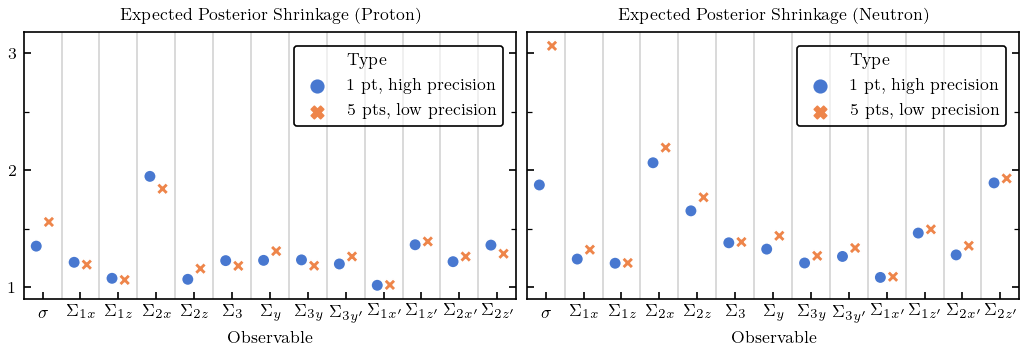

In [53]:
best_utils_npt_df_low_precision = best_utils_npt_dfs['doable', 'trunc']
best_utils_1pt_df_high_precision = best_utils_1pt_dfs['aspirational', 'trunc']

best_utils_npt_df_low_precision['Type'] = f'{n_angle_search} pts, low precision'
best_utils_1pt_df_high_precision['Type'] = '1 pt, high precision'

bests_join_pts_vs_prec_df = pd.concat([
    best_utils_npt_df_low_precision,
    best_utils_1pt_df_high_precision,
    ], sort=False)
palette = 'muted'

bests_join_pts_vs_prec_df = bests_join_pts_vs_prec_df.sort_values(by=['Observable', 'Type'], ascending=True)

fig, axes = plt.subplots(1, 2, figsize=(7, 2.5), sharey=True)

bests_join_levels_df['Subset'] == 'all'
levels_order = ['Aspirational', 'Doable', 'Standard']

sns.scatterplot(
    x='Observable', y='Shrinkage',
    data=bests_join_pts_vs_prec_df[
        (bests_join_pts_vs_prec_df['Nucleon'] == 'proton') & (bests_join_pts_vs_prec_df['Subset'] == 'all')
    ],
    hue='Type',
    style='Type',
    palette=palette,
    ax=axes[0]
)

sns.scatterplot(
    x='Observable', y='Shrinkage',
    data=bests_join_pts_vs_prec_df[
        (bests_join_pts_vs_prec_df['Nucleon'] == 'neutron') & (bests_join_pts_vs_prec_df['Subset'] == 'all')
    ],
    hue='Type',
    style='Type',
    palette=palette,
    ax=axes[1]
)

axes[1].set_ylabel('')
offset_scatterplot_data(2, axes[0])
offset_scatterplot_data(2, axes[1])

for ax in axes:
    ax.set_xticks(np.arange(2*len(observables_unique)-1)/2., minor=True)
    ax.tick_params(direction='in', which='both')
    ax.tick_params(length=0, which='minor', axis='x')
    ax.grid(True, which='minor', axis='x', color='lightgrey')

    setup_scatter_ticks(ax)
#     ax.yaxis.set_major_locator(MaxNLocator(integer=True))
#     ax.yaxis.set_minor_locator(MultipleLocator(0.5))
    ax.set_xlim([-0.5, len(observables_unique)-0.5])
axes[0].set_ylabel('')
axes[0].set_title('Expected Posterior Shrinkage (Proton)')
axes[1].set_title('Expected Posterior Shrinkage (Neutron)')

fig.tight_layout(w_pad=0.5)
plt.show()
fig.savefig(f'shrinkage_fixed_photons_subset-all')